In [1]:
import numpy as np
import pyodbc
import pandas as pd

In [2]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=51.222.82.146;DATABASE=STRATEGIO_OLAP_PROTISA;UID=Cesar_VS;PWD=Atenasmf626;Trusted_Connection=no')
query = "SELECT [CodigoDistribuidor],[CodigoFecha],SUM([VentaSinIgv]) AS Ventas FROM [STRATEGIO_OLAP_PROTISA].[pbix].[Ventas] WHERE [CodigoFecha]>='2020-01-01' and [CodigoFecha]<= '2020-12-31'  and [CodigoDistribuidor] not in ('20100239559.0','20100239559.1','20100239559.2','20100239559.3','20100239559.7','20100239559.9') GROUP BY [CodigoDistribuidor],[CodigoFecha]" 
df = pd.read_sql(query,sql_conn)

In [3]:
def transformar_data(data):
    df = data.copy()
    df['CodigoFecha'] = pd.to_datetime(df.CodigoFecha,infer_datetime_format=True)
    df['Mes'] = df['CodigoFecha'].dt.month
    distribuidor = df.groupby(['CodigoDistribuidor','Mes','CodigoFecha']).sum()
    distribuidor['Ventas_acumuladas'] = distribuidor.groupby(level=[0,1]).cumsum()
    distribuidor = distribuidor.reset_index()
    distribuidor = distribuidor[distribuidor['CodigoDistribuidor'].isin(distribuidor['CodigoDistribuidor'].value_counts()[distribuidor['CodigoDistribuidor'].value_counts() > 300].index)]
    for i in range(1,8):
        for j in ['Ventas','Ventas_acumuladas']:
            a = distribuidor.groupby(['CodigoDistribuidor','Mes','CodigoFecha'])[j].mean().groupby(level=[0,1]).shift(i).reset_index()
            distribuidor = pd.merge(distribuidor,a,on=['CodigoDistribuidor','Mes','CodigoFecha'],suffixes=('',f'_last_{i}'))
    distribuidor.fillna(0.00,inplace=True)
    distribuidor['Day'] = distribuidor.CodigoFecha.dt.day
    distribuidor['CodigoDistribuidor'] = distribuidor['CodigoDistribuidor'].astype('category')
    distribuidor['Mes'] = distribuidor['Mes'].astype('category')
    distribuidor['Day'] = distribuidor['Day'].astype('category')

    return distribuidor


In [4]:
test_df = transformar_data(df)

In [5]:
test_df.head(3)

CodigoDistribuidor Mes CodigoFecha      Ventas  Ventas_acumuladas  \
0             787878   1  2020-01-04    314.2544           314.2544   
1             787878   1  2020-01-06  26166.2452         26480.4996   
2             787878   1  2020-01-07  16151.7701         42632.2697   

   Ventas_last_1  Ventas_acumuladas_last_1  Ventas_last_2  \
0         0.0000                    0.0000         0.0000   
1       314.2544                  314.2544         0.0000   
2     26166.2452                26480.4996       314.2544   

   Ventas_acumuladas_last_2  Ventas_last_3  Ventas_acumuladas_last_3  \
0                    0.0000            0.0                       0.0   
1                    0.0000            0.0                       0.0   
2                  314.2544            0.0                       0.0   

   Ventas_last_4  Ventas_acumuladas_last_4  Ventas_last_5  \
0            0.0                       0.0            0.0   
1            0.0                       0.0            0.0   
2            0.0                       0.0            0.0   

   Ventas_acumuladas_last_5  Ventas_last_6  Ventas_acumuladas_last_6  \
0                       0.0            0.0                       0.0   
1                       0.0            0.0                       0.0   
2                       0.0            0.0                       0.0   

   Ventas_last_7  Ventas_acumuladas_last_7 Day  
0            0.0                       0.0   4  
1            0.0                       0.0   6  
2            0.0                       0.0   7

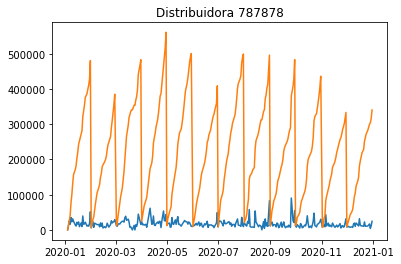

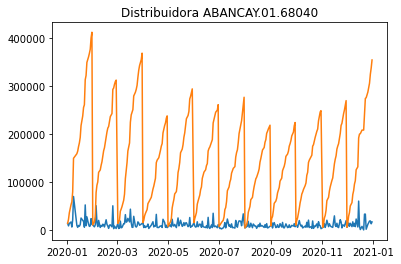

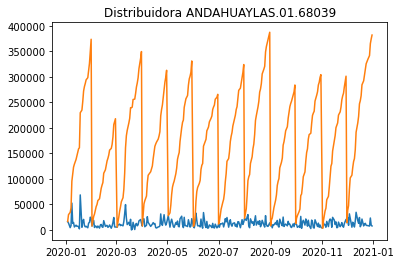

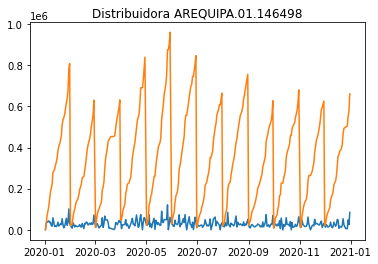

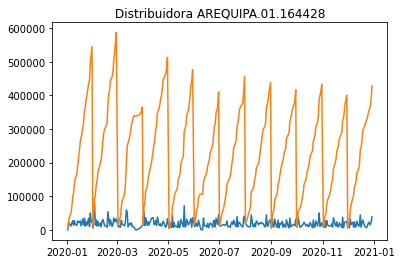

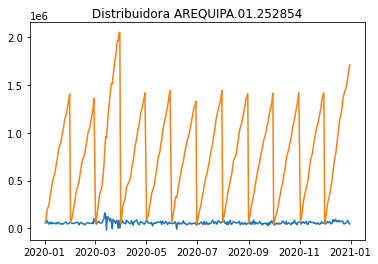

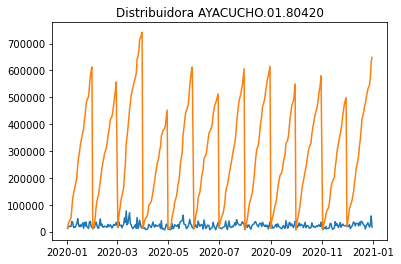

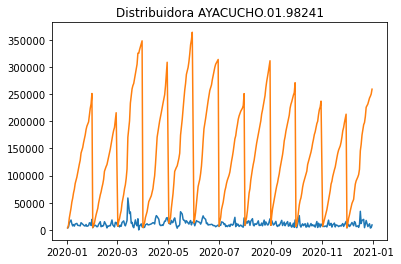

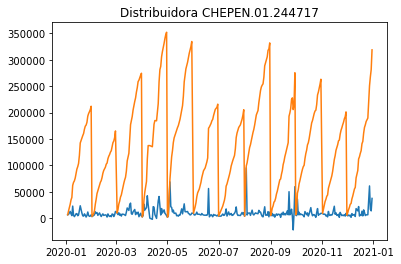

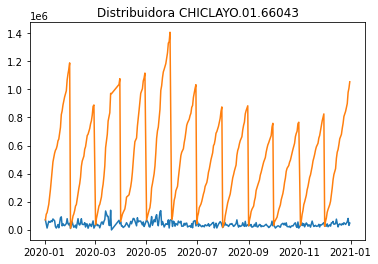

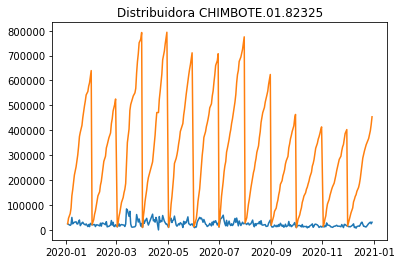

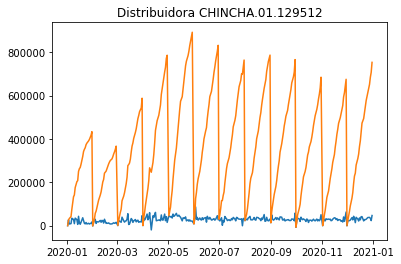

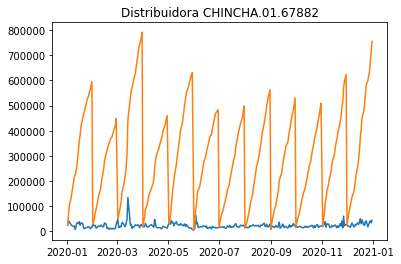

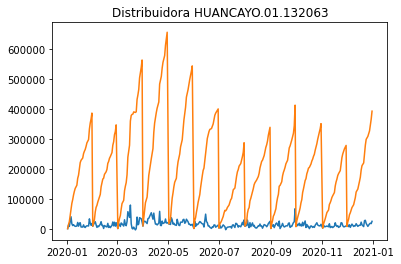

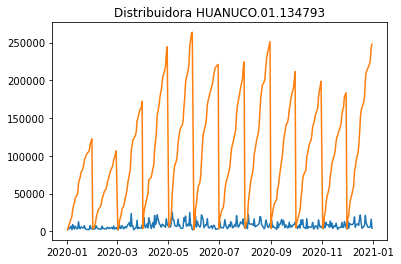

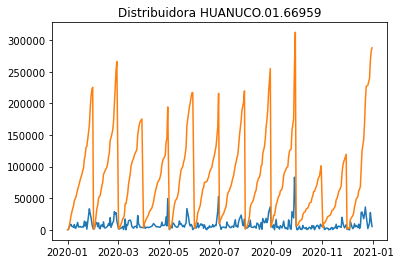

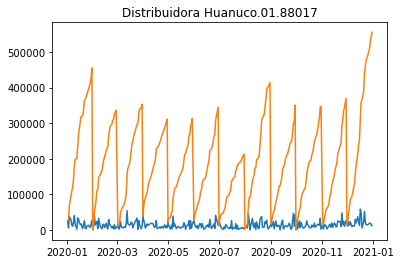

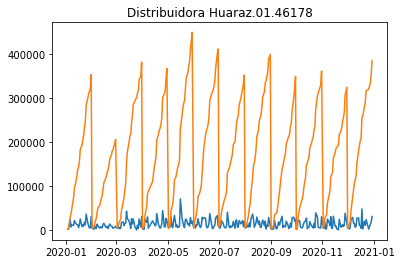

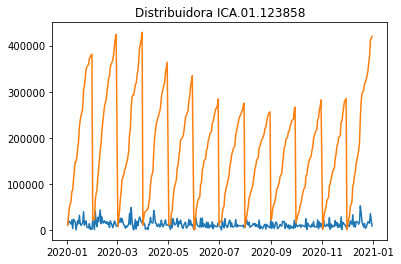

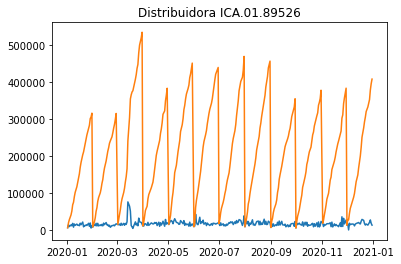

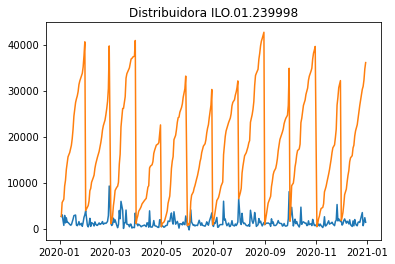

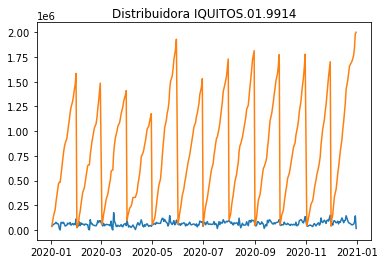

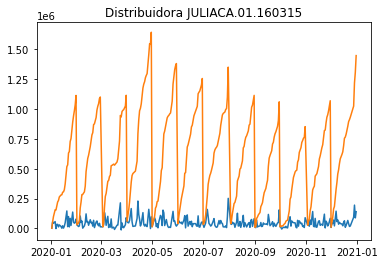

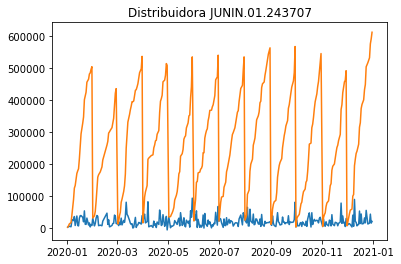

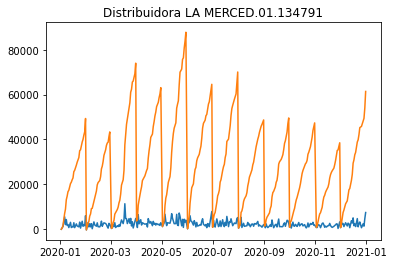

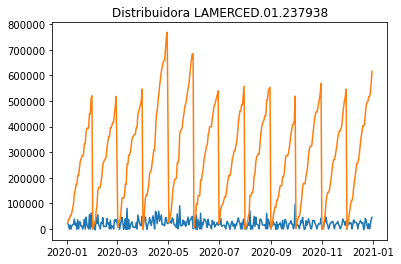

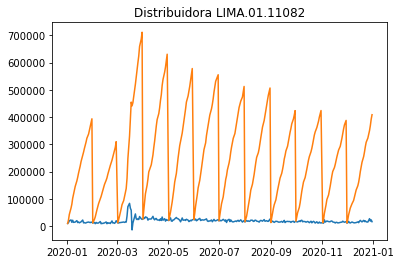

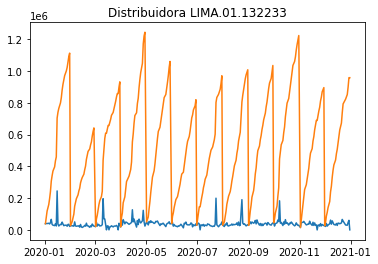

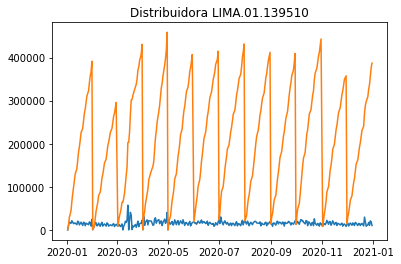

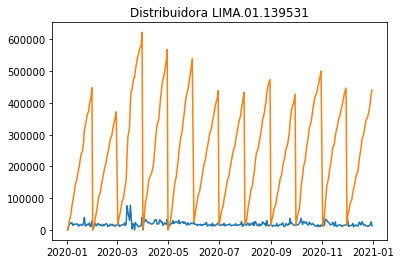

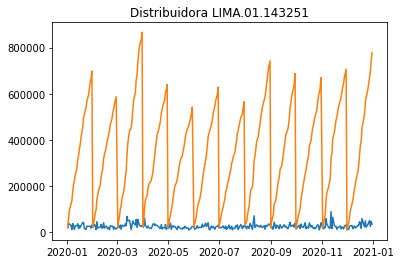

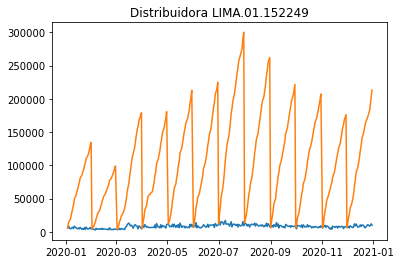

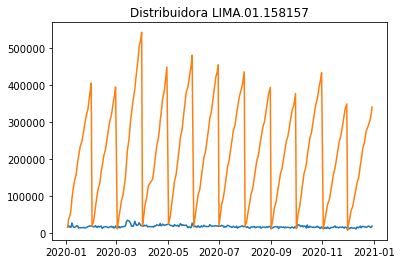

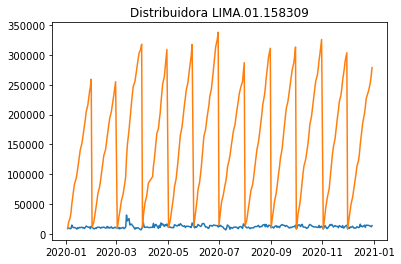

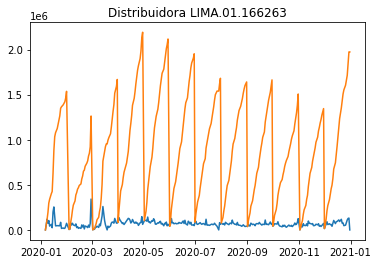

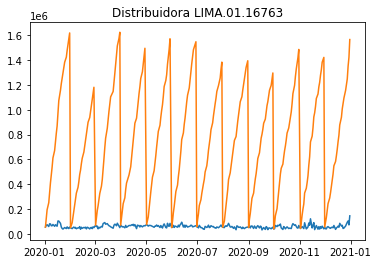

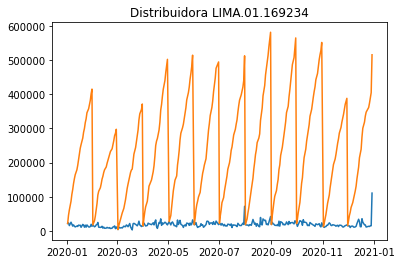

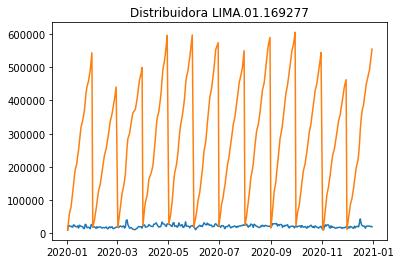

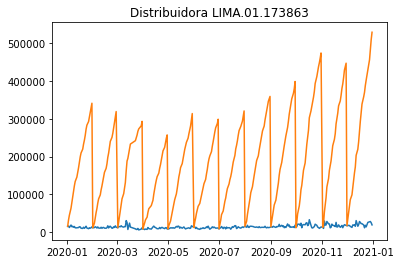

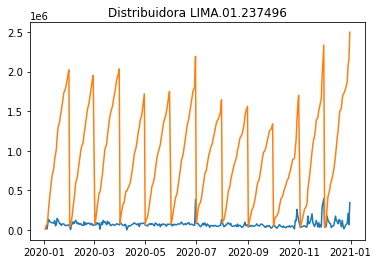

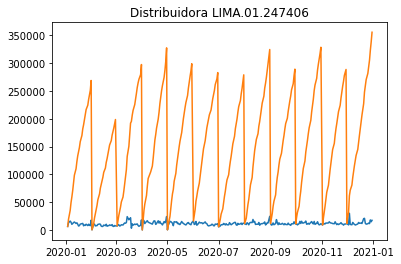

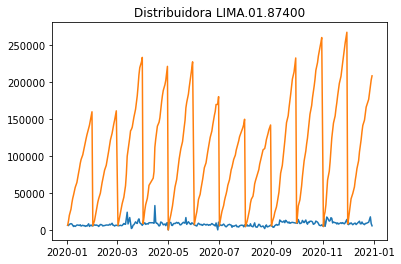

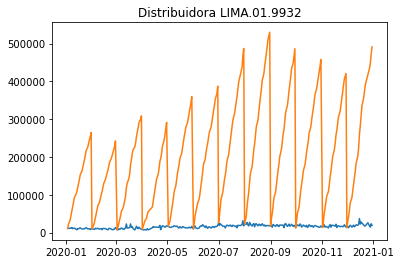

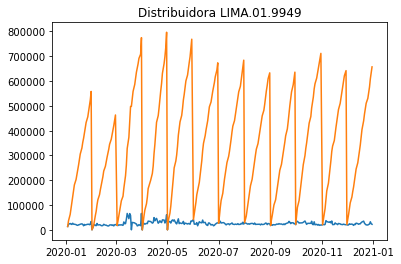

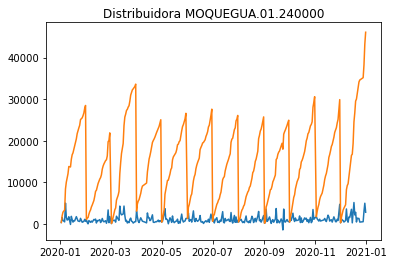

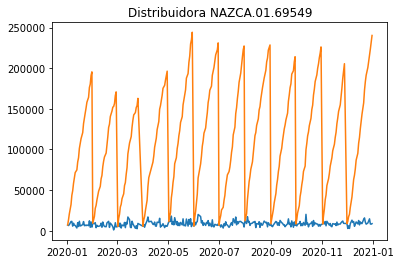

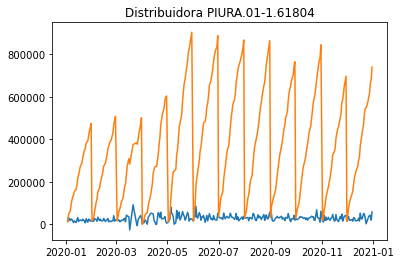

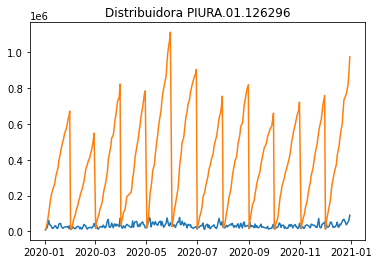

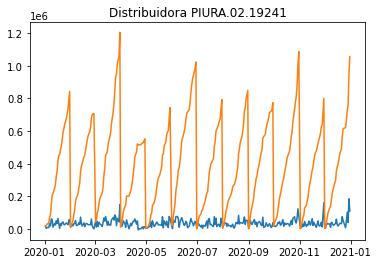

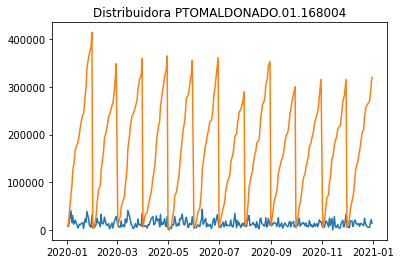

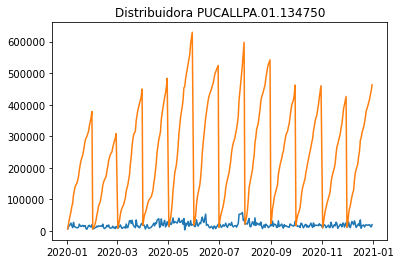

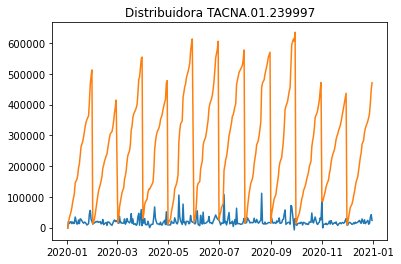

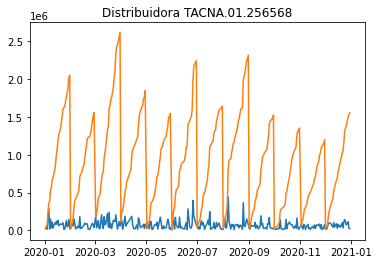

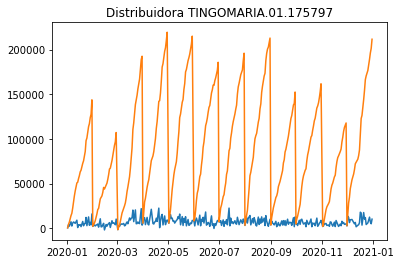

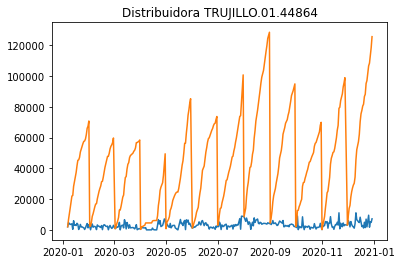

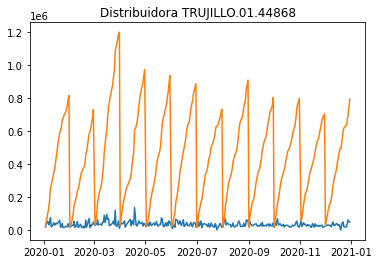

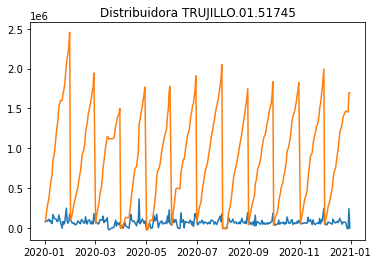

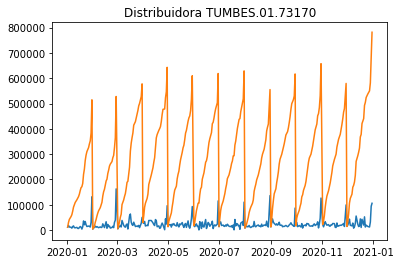

In [6]:
import matplotlib.pyplot as plt

dist_names = test_df.CodigoDistribuidor.unique()
for i in dist_names:
    plt.plot(test_df[test_df['CodigoDistribuidor']==i]['CodigoFecha'], test_df[test_df['CodigoDistribuidor']==i]['Ventas'])
    plt.plot(test_df[test_df['CodigoDistribuidor']==i]['CodigoFecha'], test_df[test_df['CodigoDistribuidor']==i]['Ventas_acumuladas'])
    plt.title(f'Distribuidora {i}')
    plt.show()

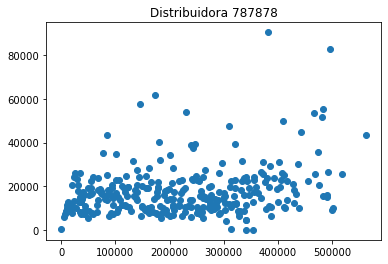

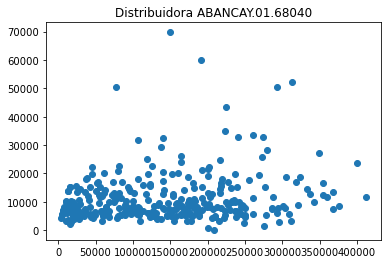

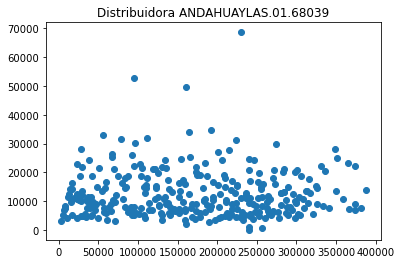

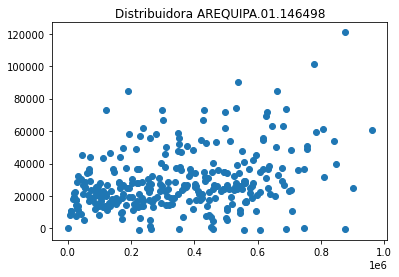

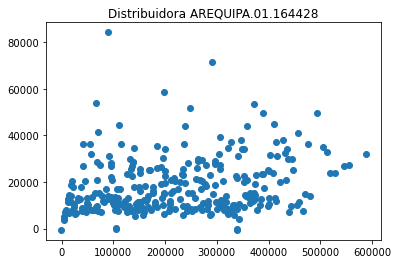

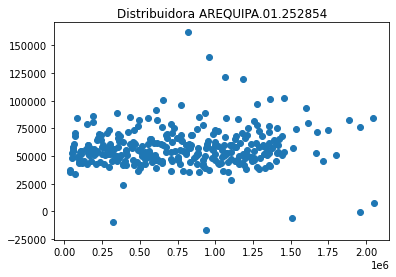

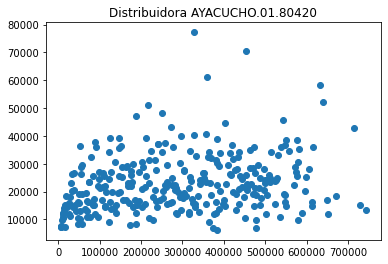

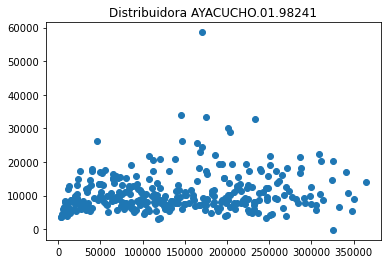

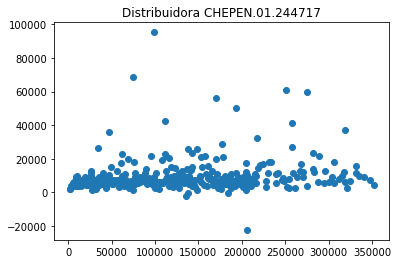

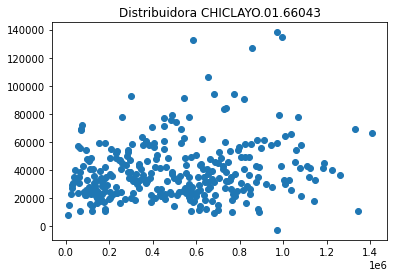

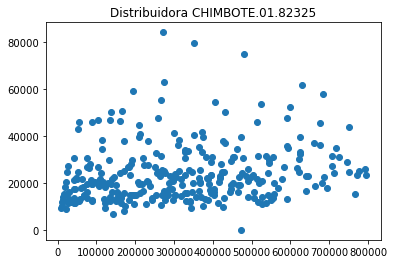

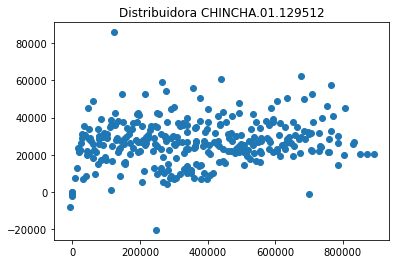

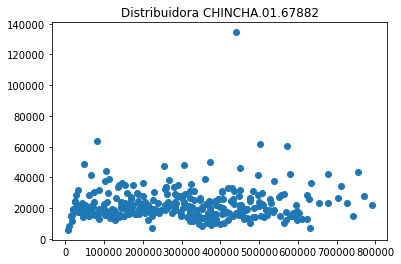

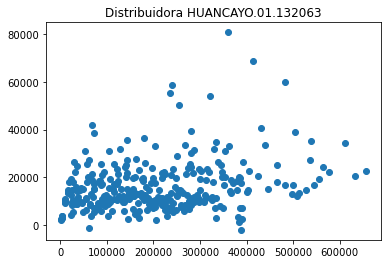

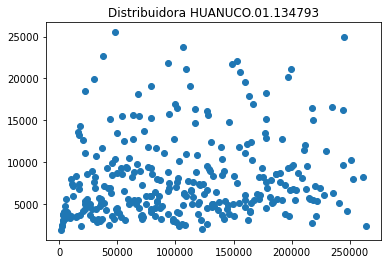

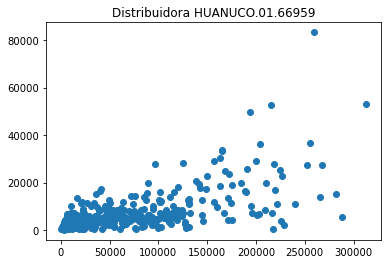

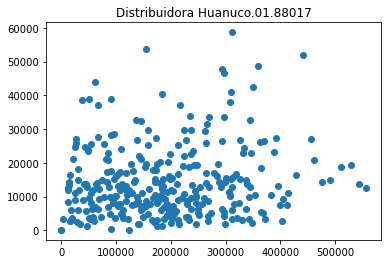

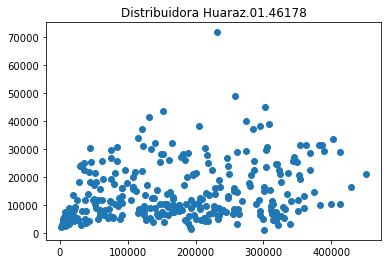

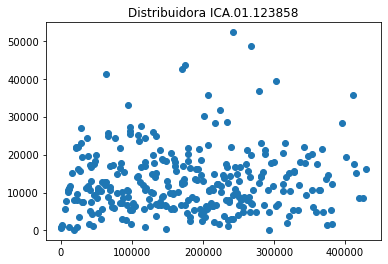

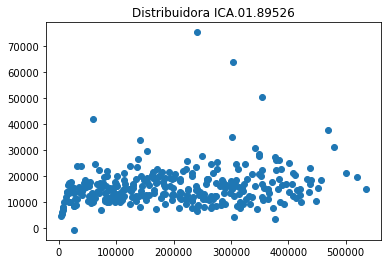

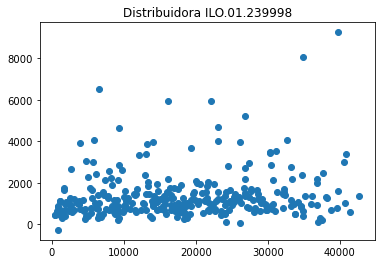

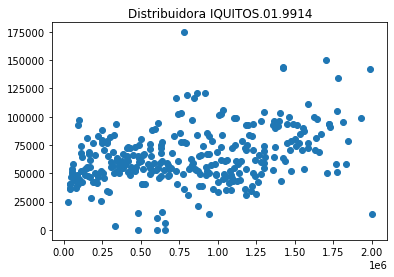

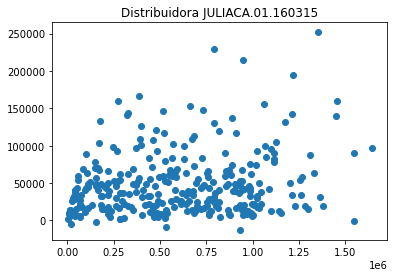

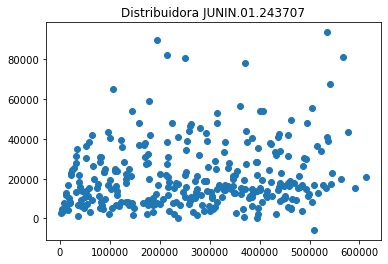

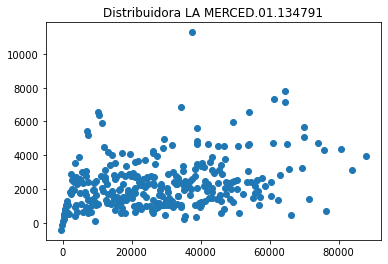

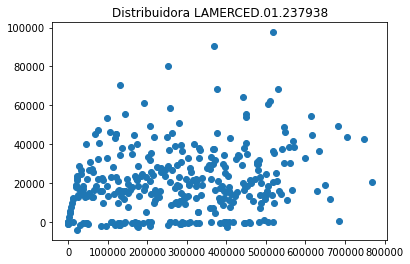

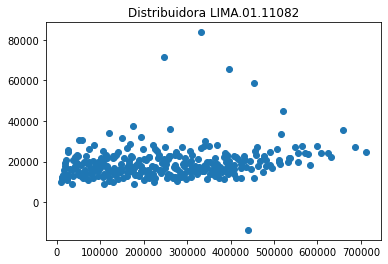

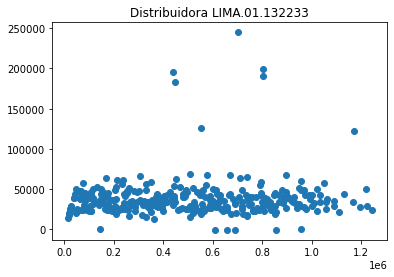

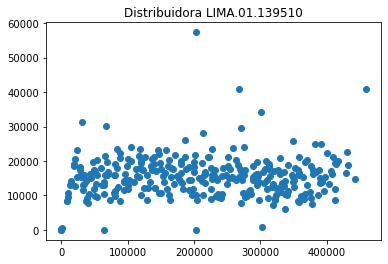

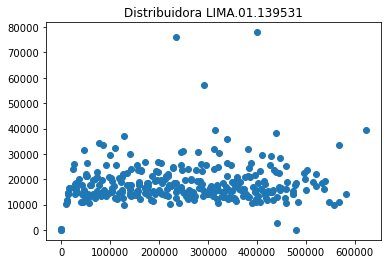

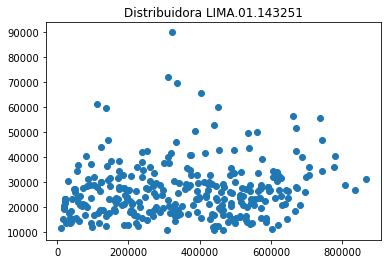

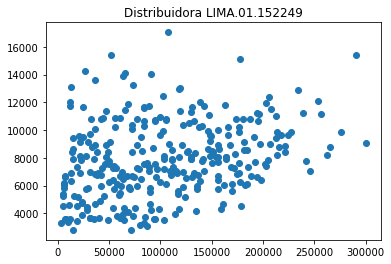

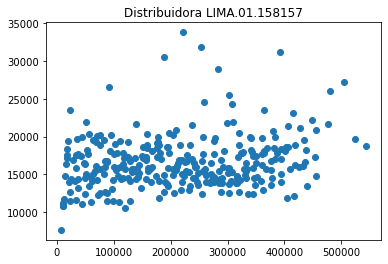

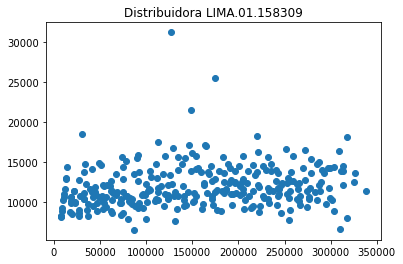

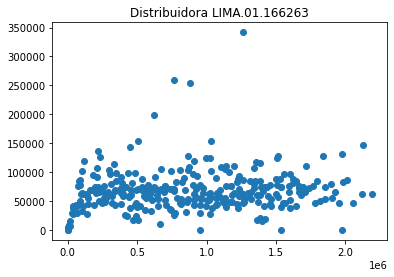

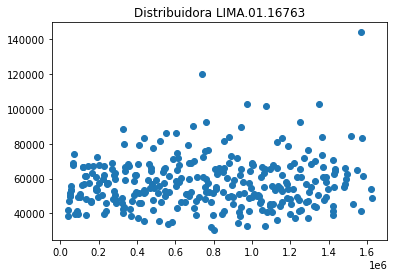

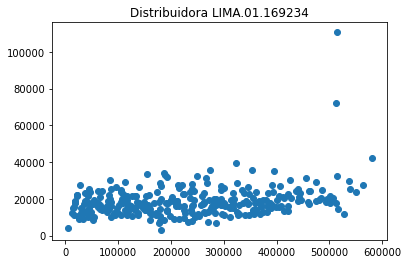

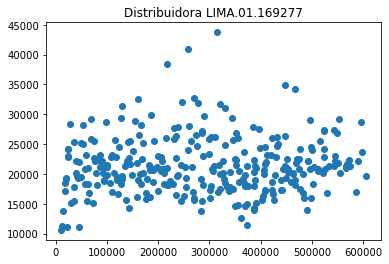

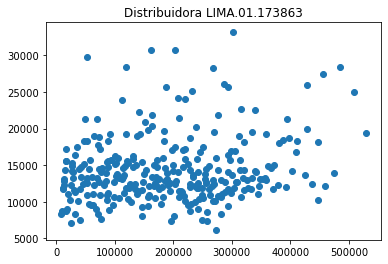

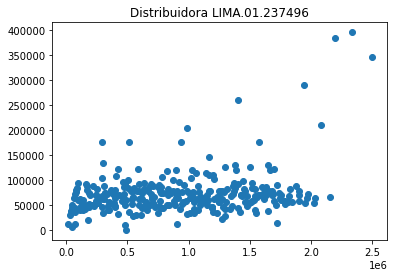

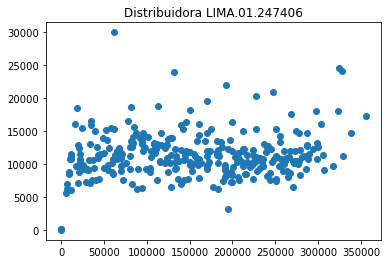

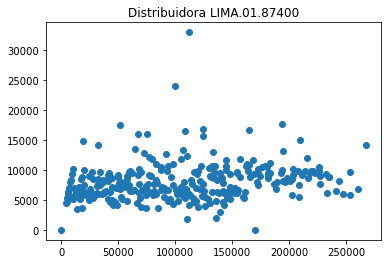

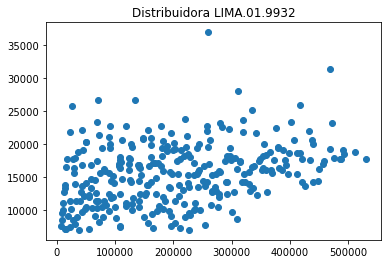

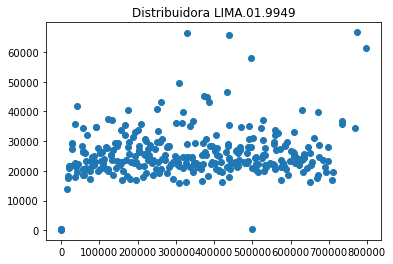

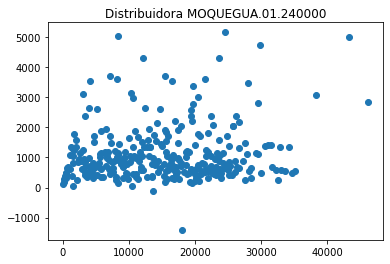

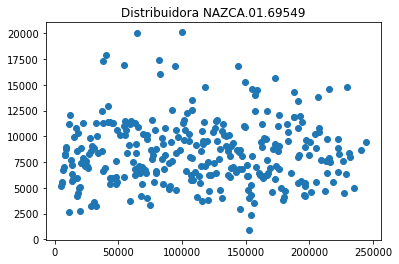

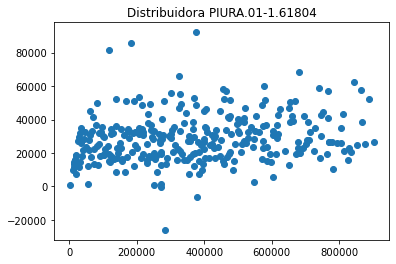

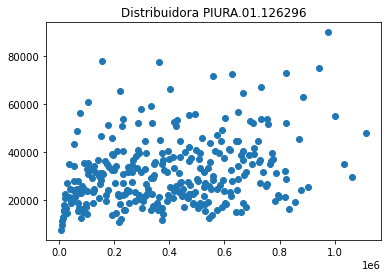

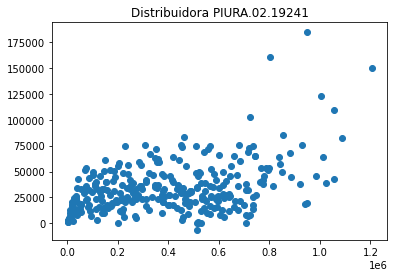

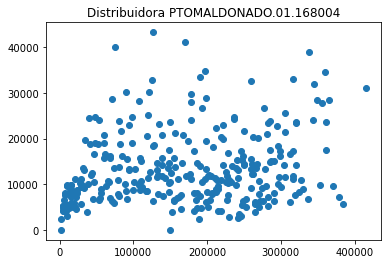

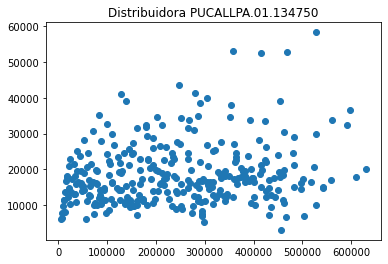

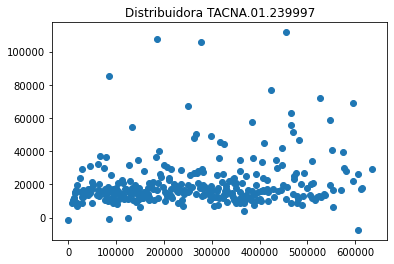

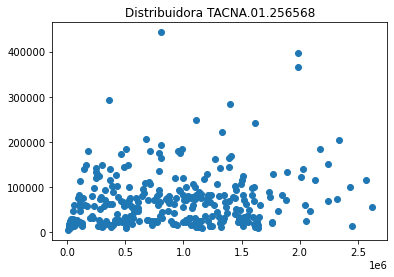

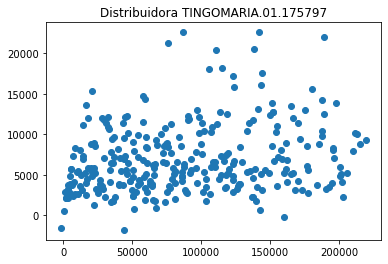

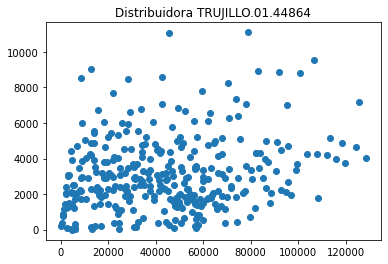

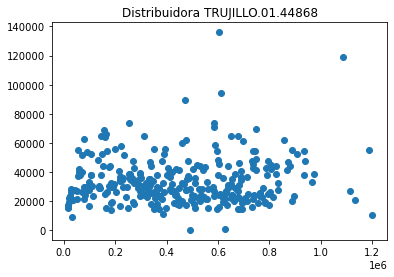

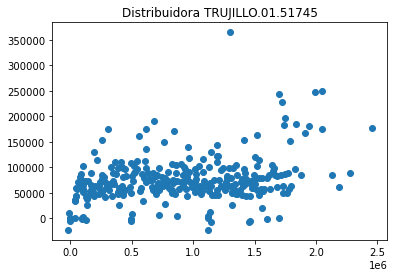

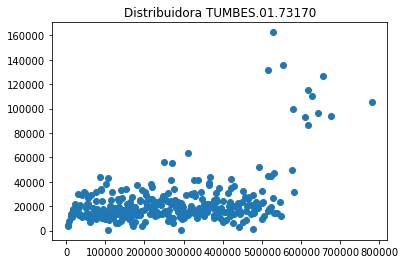

In [7]:
import matplotlib.pyplot as plt

dist_names = test_df.CodigoDistribuidor.unique()
for i in dist_names:
    plt.scatter(test_df[test_df['CodigoDistribuidor']==i]['Ventas_acumuladas'], test_df[test_df['CodigoDistribuidor']==i]['Ventas'])
    plt.title(f'Distribuidora {i}')
    plt.show()

In [8]:
test_df.to_csv('data.csv')

In [9]:
test_df.isnull().sum()

CodigoDistribuidor          0
Mes                         0
CodigoFecha                 0
Ventas                      0
Ventas_acumuladas           0
Ventas_last_1               0
Ventas_acumuladas_last_1    0
Ventas_last_2               0
Ventas_acumuladas_last_2    0
Ventas_last_3               0
Ventas_acumuladas_last_3    0
Ventas_last_4               0
Ventas_acumuladas_last_4    0
Ventas_last_5               0
Ventas_acumuladas_last_5    0
Ventas_last_6               0
Ventas_acumuladas_last_6    0
Ventas_last_7               0
Ventas_acumuladas_last_7    0
Day                         0
dtype: int64

# Armamos el modelo ElasticNet

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [11]:
test_df.columns

Index(['CodigoDistribuidor', 'Mes', 'CodigoFecha', 'Ventas',
       'Ventas_acumuladas', 'Ventas_last_1', 'Ventas_acumuladas_last_1',
       'Ventas_last_2', 'Ventas_acumuladas_last_2', 'Ventas_last_3',
       'Ventas_acumuladas_last_3', 'Ventas_last_4', 'Ventas_acumuladas_last_4',
       'Ventas_last_5', 'Ventas_acumuladas_last_5', 'Ventas_last_6',
       'Ventas_acumuladas_last_6', 'Ventas_last_7', 'Ventas_acumuladas_last_7',
       'Day'],
      dtype='object')

In [12]:
X = test_df.drop(['Ventas','Ventas_acumuladas','CodigoFecha'],axis=1)
y = test_df[['Ventas_acumuladas']]
cat_cols = ['CodigoDistribuidor','Mes','Day']
num_cols = ['Ventas_last_1','Ventas_last_2','Ventas_last_3','Ventas_last_4','Ventas_last_5','Ventas_last_6','Ventas_last_7','Ventas_acumuladas_last_1','Ventas_acumuladas_last_2','Ventas_acumuladas_last_3','Ventas_acumuladas_last_4','Ventas_acumuladas_last_5','Ventas_acumuladas_last_6','Ventas_acumuladas_last_7']

In [13]:
cat_encoder = OneHotEncoder(handle_unknown='ignore')
num_pipe = MaxAbsScaler()
preprocessing = ColumnTransformer([('cat',cat_encoder,cat_cols),('num',num_pipe,num_cols)])
model = ElasticNet()
steps = [('preprocess', preprocessing), ('elasticnet', model)]
pipeline = Pipeline(steps)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=126)

In [14]:
parameters = {'elasticnet__l1_ratio':np.linspace(0, 1, 30)}
gm_cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [15]:
gm_cv.fit(X_train,y_train)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492752434887570.8, tolerance: 114373565757.31508
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 507067567322804.25, tolerance: 114788213737.5327
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510714634843924.0, tolerance: 115979679302.12988
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:51

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['CodigoDistribuidor',
                                                                          'Mes',
                                                                          'Day']),
                                                                        ('num',
                                                                         MaxAbsScaler(),
                                                                         ['Ventas_last_1',
                                                                          'Ventas_last_2',
                                                                          'Ventas_last_3',
                                

In [16]:
r2 = gm_cv.score(X_test, y_test)
print('R^2:',r2)

R^2: 0.9974985701104602


In [17]:
y_pred = gm_cv.predict(X_test)

In [18]:
from sklearn.metrics import mean_squared_error

print('RSME:',np.sqrt(mean_squared_error(y_test,y_pred)))

RSME: 16203.708873634638


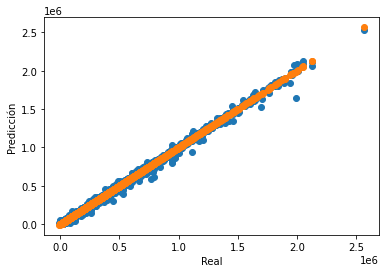

In [19]:
_ = plt.scatter(y_test,y_pred)
_ = plt.scatter(y_test,y_test)
_ = plt.xlabel('Real')
_ = plt.ylabel('Predicción')
plt.show()

In [20]:
test_df['prediccion'] = gm_cv.predict(X)

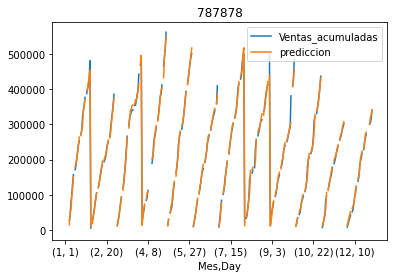

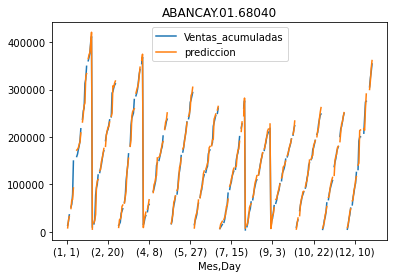

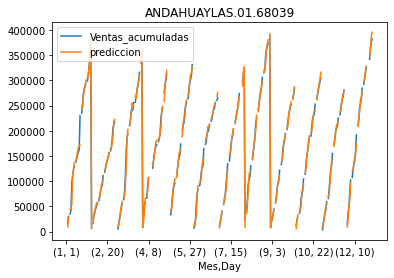

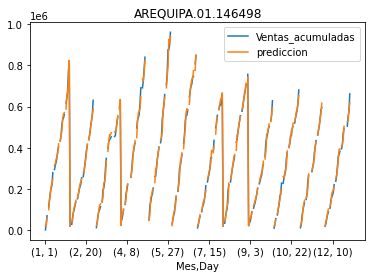

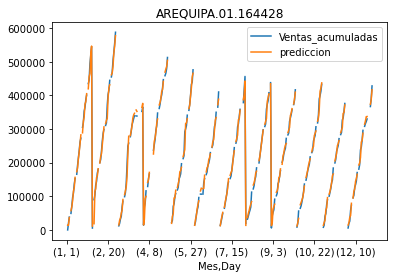

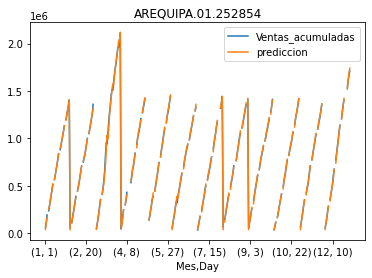

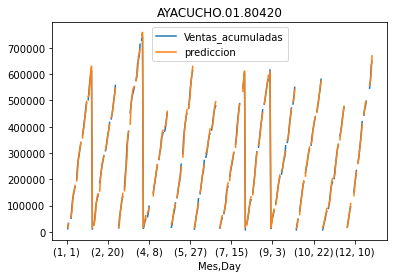

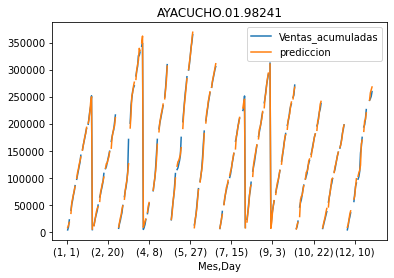

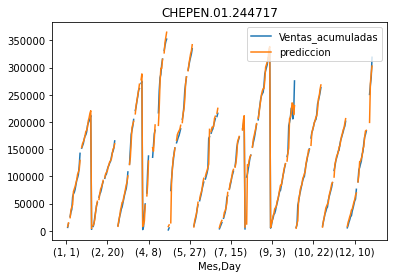

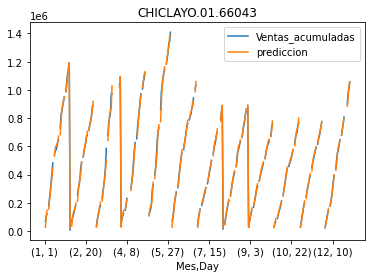

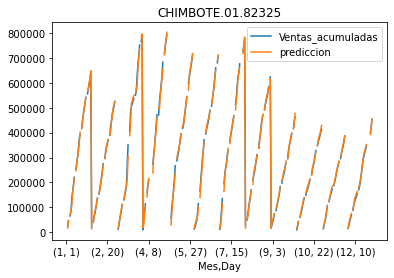

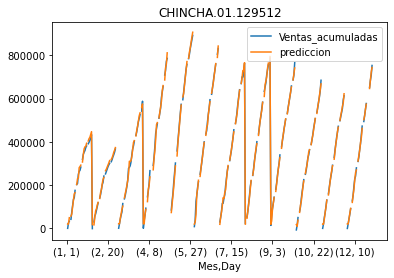

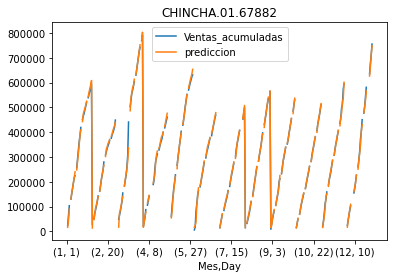

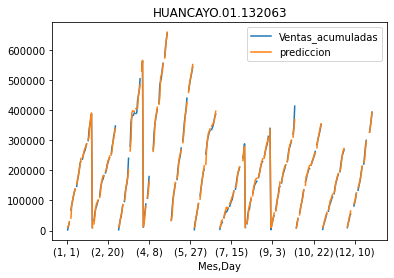

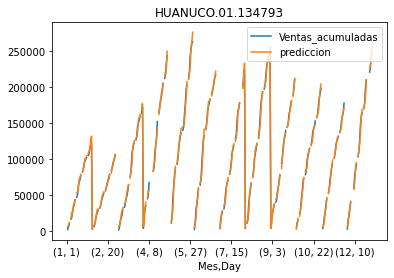

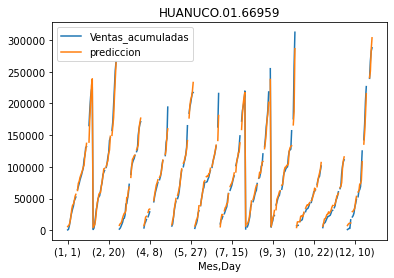

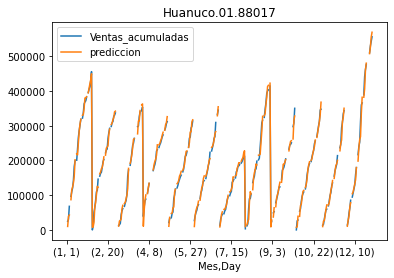

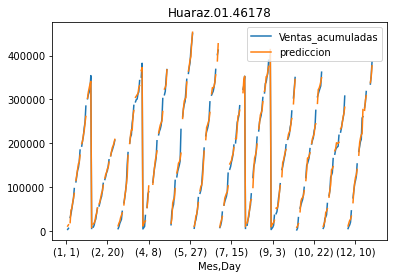

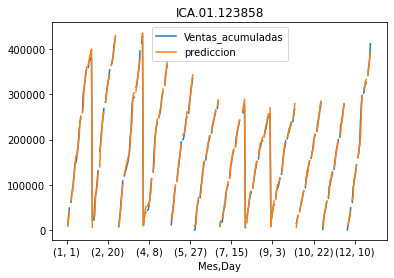

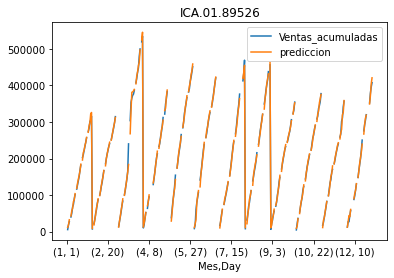

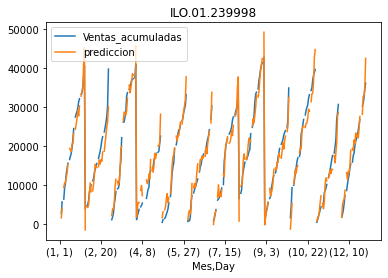

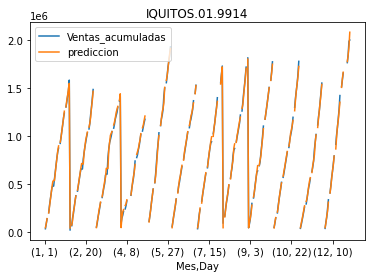

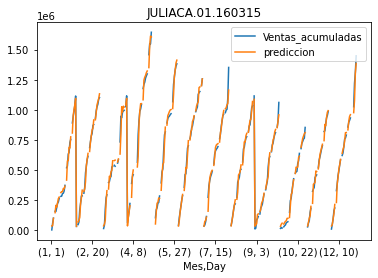

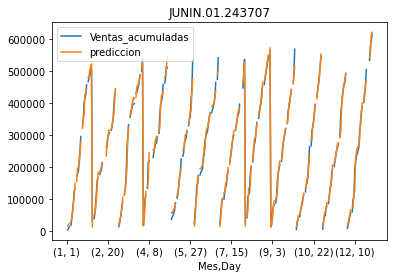

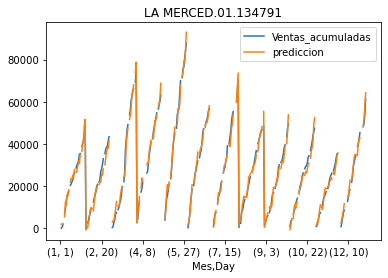

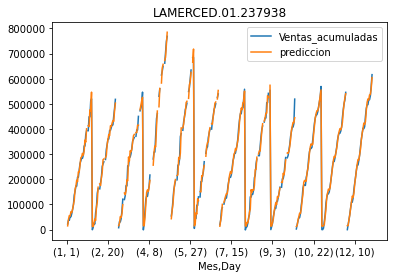

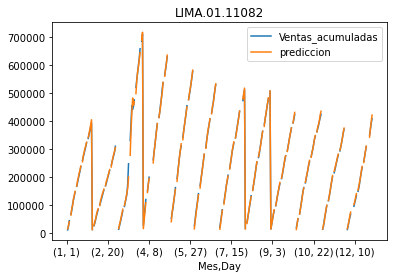

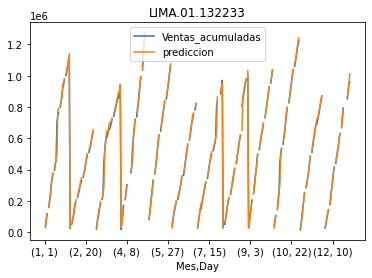

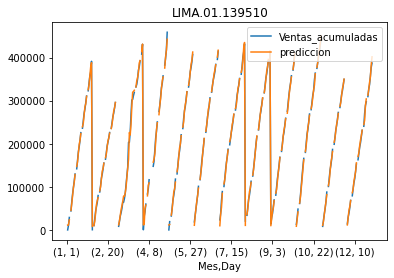

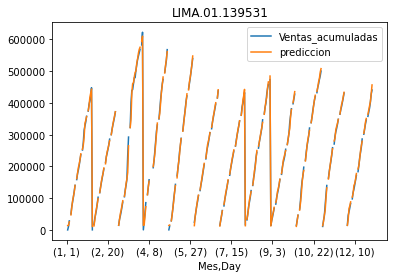

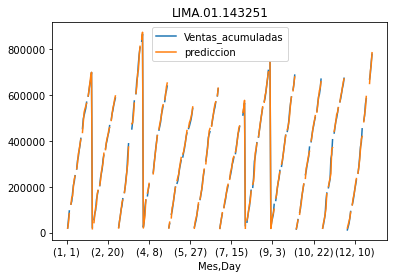

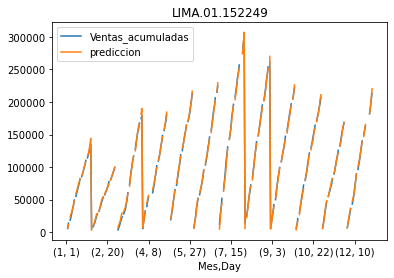

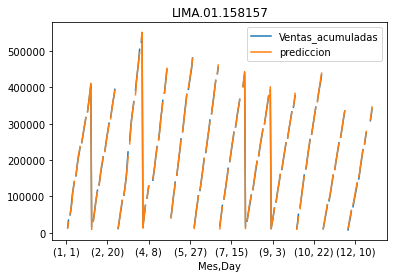

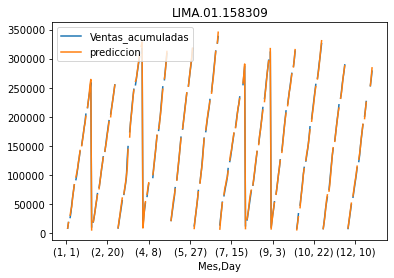

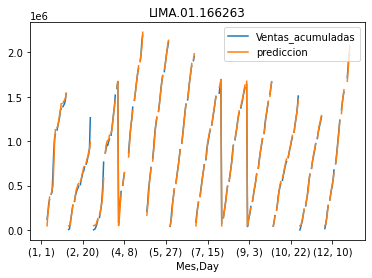

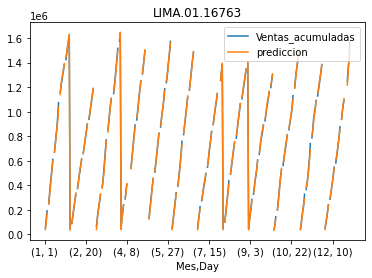

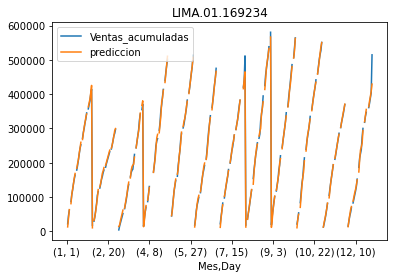

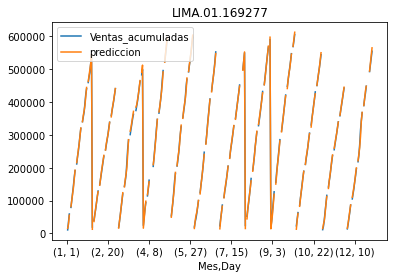

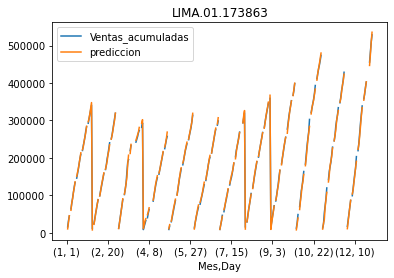

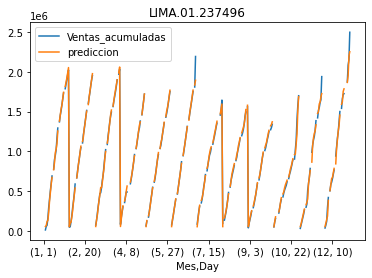

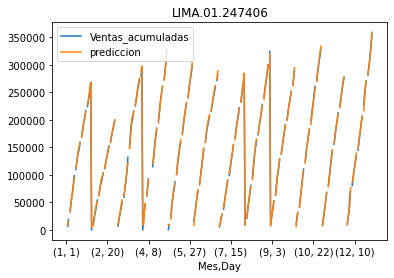

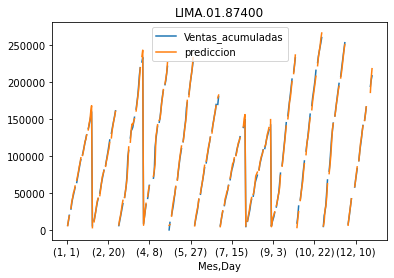

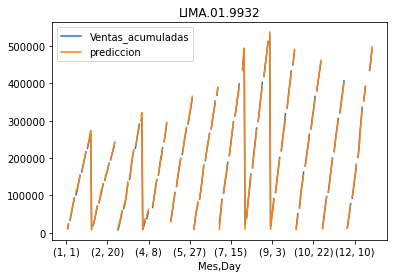

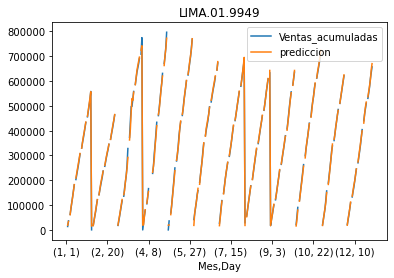

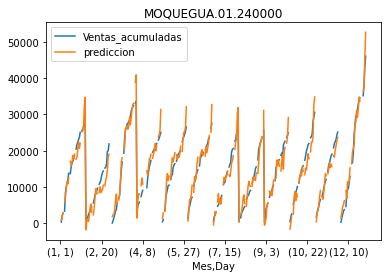

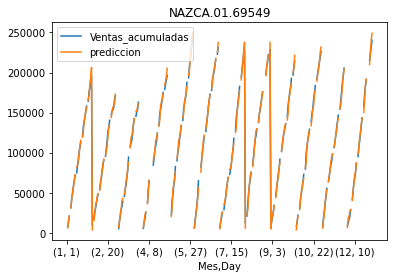

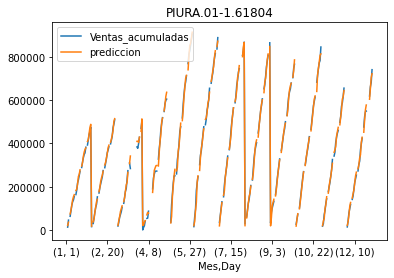

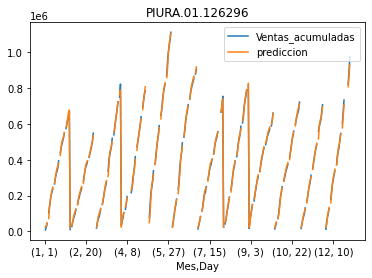

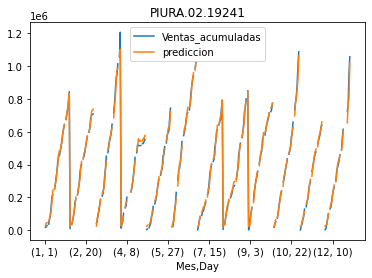

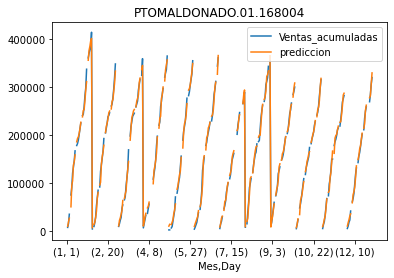

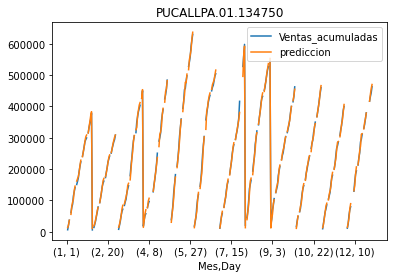

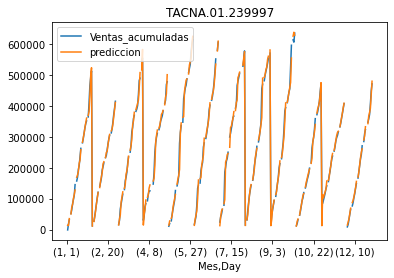

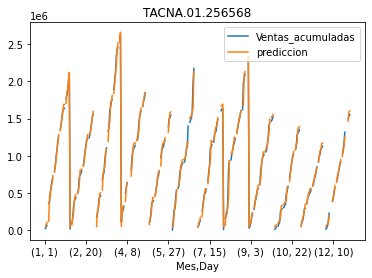

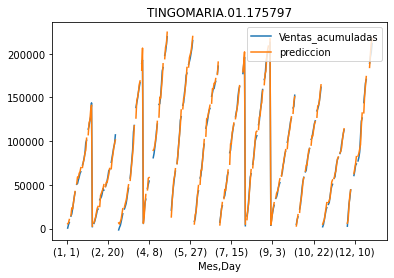

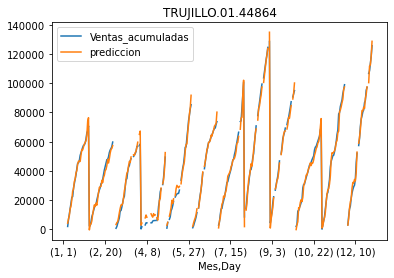

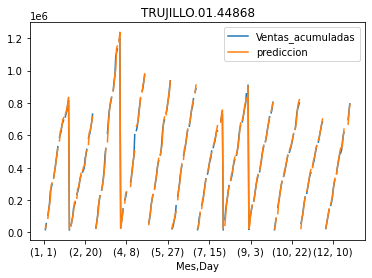

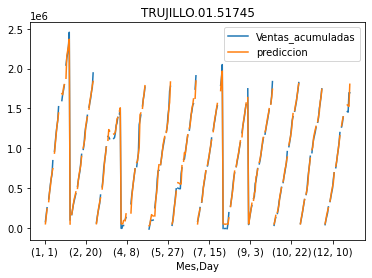

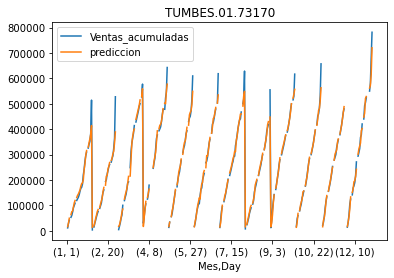

In [21]:
for i in test_df.CodigoDistribuidor.unique():
    _ = test_df[test_df.CodigoDistribuidor == i].groupby(['Mes','Day'])[['Ventas_acumuladas','prediccion']].mean().plot()
    _ = plt.title(i)
    plt.show()

In [22]:
print(gm_cv.best_params_)
results = pd.DataFrame(gm_cv.cv_results_)
results

{'elasticnet__l1_ratio': 1.0}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        4.243946      0.018455         0.011046        0.003724   
1        0.047023      0.006710         0.007843        0.006984   
2        0.055119      0.006940         0.000000        0.000000   
3        0.047188      0.007315         0.009055        0.005947   
4        0.046995      0.005495         0.007660        0.006993   
5        0.045515      0.007911         0.004743        0.006276   
6        0.047000      0.005379         0.004525        0.006175   
7        0.052125      0.004227         0.007403        0.000493   
8        0.051807      0.002675         0.007004        0.003302   
9        0.046336      0.005792         0.008465        0.003645   
10       0.054971      0.002647         0.007389        0.000798   
11       0.051362      0.005030         0.005927        0.005779   
12       0.056062      0.001616         0.008179        0.000400   
13       0.052719      0.006313         0.008725        0.003449   
14       0.048903      0.002132         0.006998        0.007673   
15       0.051924      0.006754         0.010264        0.005963   
16       0.050252      0.005837         0.006927        0.005169   
17       0.052713      0.010395         0.007647        0.006994   
18       0.051604      0.008874         0.010778        0.006339   
19       0.051594      0.005964         0.006238        0.007639   
20       0.059934      0.002938         0.006977        0.003510   
21       0.057369      0.001934         0.008182        0.000410   
22       0.054939      0.007240         0.009916        0.002885   
23       0.053911      0.007528         0.011165        0.006149   
24       0.063941      0.006422         0.003203        0.003923   
25       0.064358      0.002742         0.005685        0.002111   
26       0.066390      0.008609         0.009924        0.002896   
27       0.072920      0.005942         0.008910        0.003377   
28       0.090797      0.001933         0.007592        0.000476   
29       4.190944      0.035718         0.005919        0.005770   

   param_elasticnet__l1_ratio                                          params  \
0                           0                   {'elasticnet__l1_ratio': 0.0}   
1                   0.0344828  {'elasticnet__l1_ratio': 0.034482758620689655}   
2                   0.0689655   {'elasticnet__l1_ratio': 0.06896551724137931}   
3                    0.103448   {'elasticnet__l1_ratio': 0.10344827586206896}   
4                    0.137931   {'elasticnet__l1_ratio': 0.13793103448275862}   
5                    0.172414    {'elasticnet__l1_ratio': 0.1724137931034483}   
6                    0.206897   {'elasticnet__l1_ratio': 0.20689655172413793}   
7                    0.241379   {'elasticnet__l1_ratio': 0.24137931034482757}   
8                    0.275862   {'elasticnet__l1_ratio': 0.27586206896551724}   
9                    0.310345    {'elasticnet__l1_ratio': 0.3103448275862069}   
10                   0.344828    {'elasticnet__l1_ratio': 0.3448275862068966}   
11                    0.37931    {'elasticnet__l1_ratio': 0.3793103448275862}   
12                   0.413793   {'elasticnet__l1_ratio': 0.41379310344827586}   
13                   0.448276    {'elasticnet__l1_ratio': 0.4482758620689655}   
14                   0.482759   {'elasticnet__l1_ratio': 0.48275862068965514}   
15                   0.517241    {'elasticnet__l1_ratio': 0.5172413793103449}   
16                   0.551724    {'elasticnet__l1_ratio': 0.5517241379310345}   
17                   0.586207    {'elasticnet__l1_ratio': 0.5862068965517241}   
18                    0.62069    {'elasticnet__l1_ratio': 0.6206896551724138}   
19                   0.655172    {'elasticnet__l1_ratio': 0.6551724137931034}   
20                   0.689655    {'elasticnet__l1_ratio': 0.6896551724137931}   
21                   0.724138    {'elasticnet__l1_ratio': 0.7241379310344828}   
22                   0.758621   

# Probamos como se desenvuelve el modelo en el año 2021

In [23]:
query = "SELECT [CodigoDistribuidor],[CodigoFecha],SUM([VentaSinIgv]) AS Ventas FROM [STRATEGIO_OLAP_PROTISA].[pbix].[Ventas] WHERE [CodigoFecha]>='2021-01-01' and [CodigoFecha]<= getdate()  and [CodigoDistribuidor] not in ('20100239559.0','20100239559.1','20100239559.2','20100239559.3','20100239559.7','20100239559.9') GROUP BY [CodigoDistribuidor],[CodigoFecha]" 
df_2 = pd.read_sql(query,sql_conn)

In [24]:
def transformar_data_2(data):
    df = data.copy()
    df['CodigoFecha'] = pd.to_datetime(df.CodigoFecha,infer_datetime_format=True)
    df['Mes'] = df['CodigoFecha'].dt.month
    distribuidor = df.groupby(['CodigoDistribuidor','Mes','CodigoFecha']).sum()
    distribuidor['Ventas_acumuladas'] = distribuidor.groupby(level=[0,1]).cumsum()
    distribuidor = distribuidor.reset_index()
    distribuidor = distribuidor[distribuidor['CodigoDistribuidor'].isin(distribuidor['CodigoDistribuidor'].value_counts()[distribuidor['CodigoDistribuidor'].value_counts() > 70].index)]
    for i in range(1,8):
        for j in ['Ventas','Ventas_acumuladas']:
            a = distribuidor.groupby(['CodigoDistribuidor','Mes','CodigoFecha'])[j].mean().groupby(level=[0,1]).shift(i).reset_index()
            distribuidor = pd.merge(distribuidor,a,on=['CodigoDistribuidor','Mes','CodigoFecha'],suffixes=('',f'_last_{i}'))
    distribuidor.fillna(0.00,inplace=True)
    distribuidor['Day'] = distribuidor.CodigoFecha.dt.day
    distribuidor['CodigoDistribuidor'] = distribuidor['CodigoDistribuidor'].astype('category')
    distribuidor['Mes'] = distribuidor['Mes'].astype('category')
    distribuidor['Day'] = distribuidor['Day'].astype('category')

    return distribuidor


In [25]:
test_data_2021 = transformar_data_2(df_2)

In [26]:
test_data_2021.columns

Index(['CodigoDistribuidor', 'Mes', 'CodigoFecha', 'Ventas',
       'Ventas_acumuladas', 'Ventas_last_1', 'Ventas_acumuladas_last_1',
       'Ventas_last_2', 'Ventas_acumuladas_last_2', 'Ventas_last_3',
       'Ventas_acumuladas_last_3', 'Ventas_last_4', 'Ventas_acumuladas_last_4',
       'Ventas_last_5', 'Ventas_acumuladas_last_5', 'Ventas_last_6',
       'Ventas_acumuladas_last_6', 'Ventas_last_7', 'Ventas_acumuladas_last_7',
       'Day'],
      dtype='object')

In [27]:
X_2021 = test_data_2021.drop(['Ventas','Ventas_acumuladas','CodigoFecha'],axis=1)
test_data_2021['prediccion'] = gm_cv.predict(X_2021)

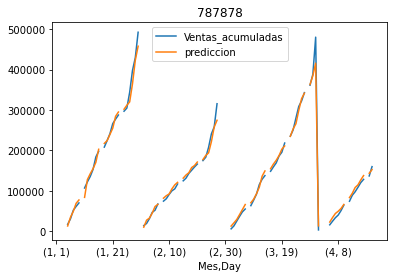

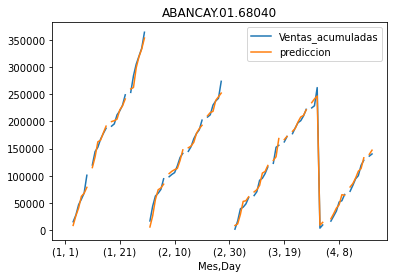

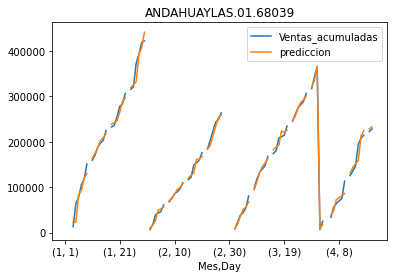

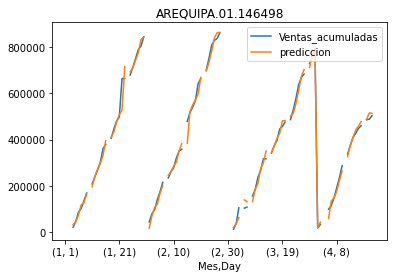

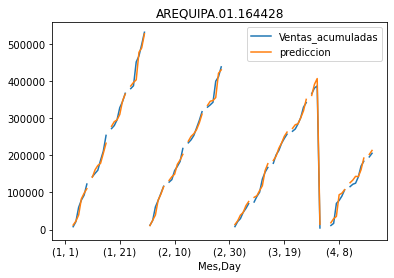

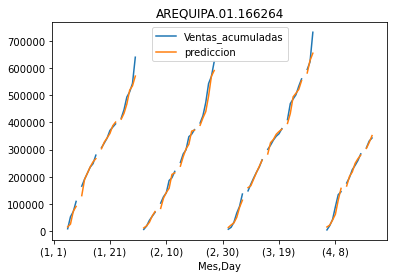

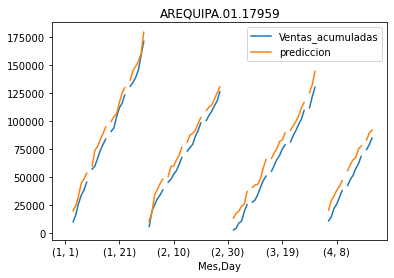

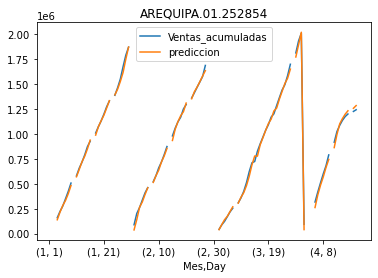

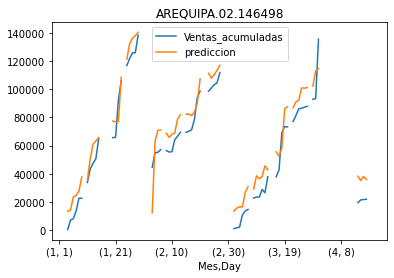

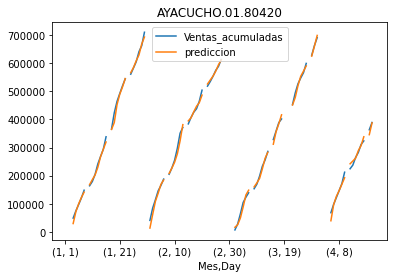

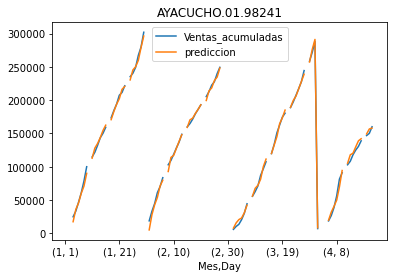

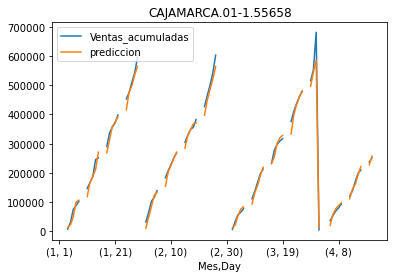

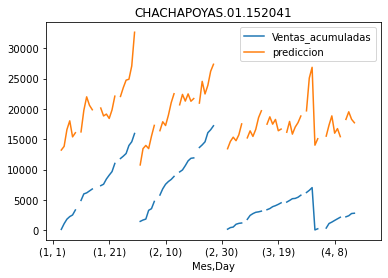

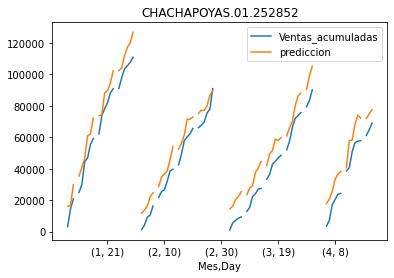

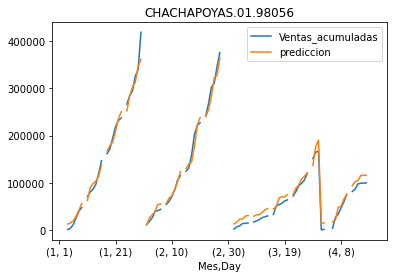

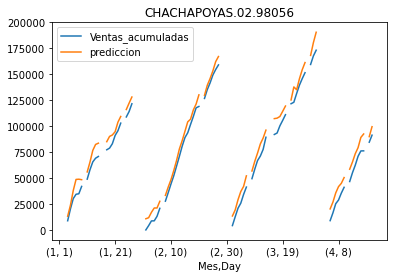

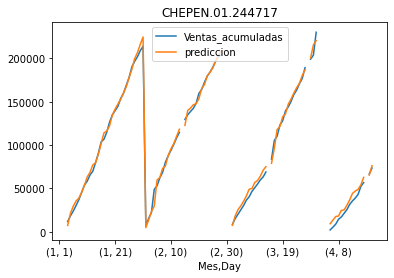

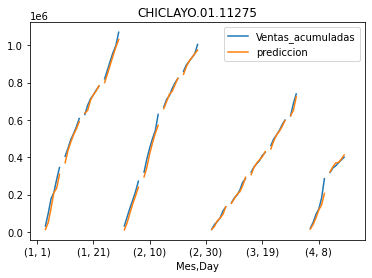

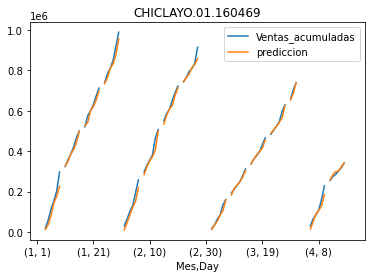

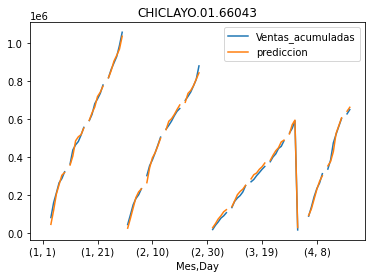

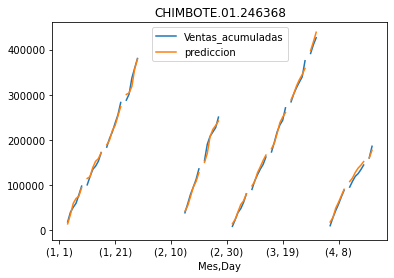

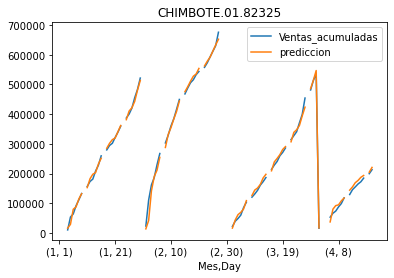

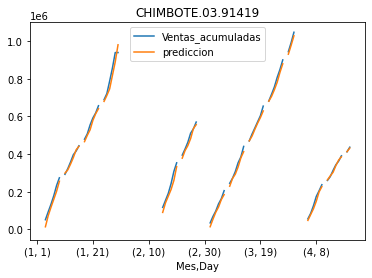

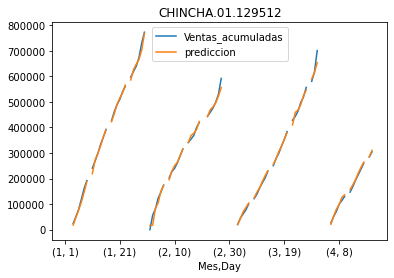

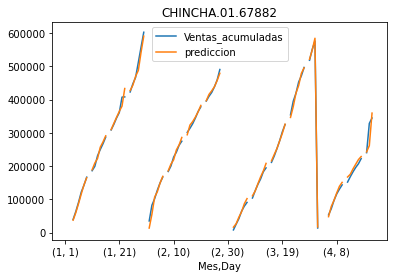

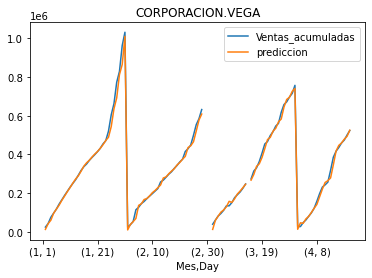

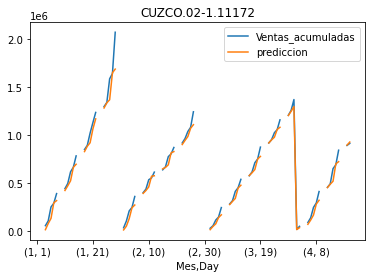

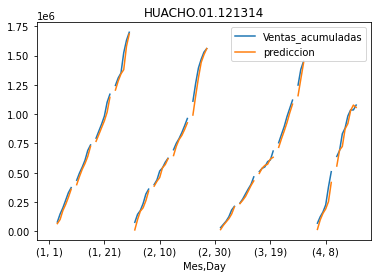

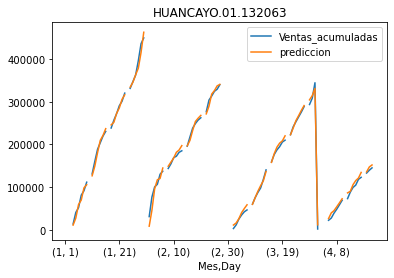

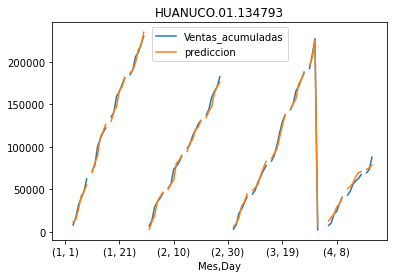

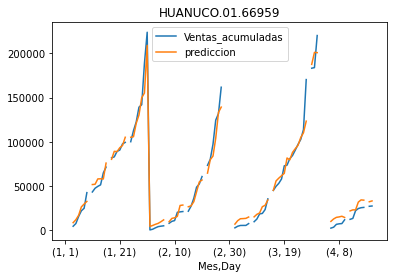

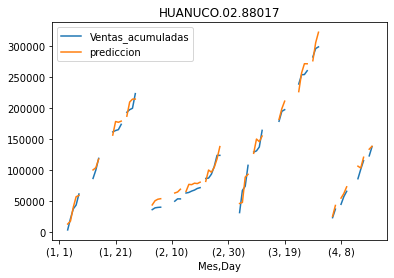

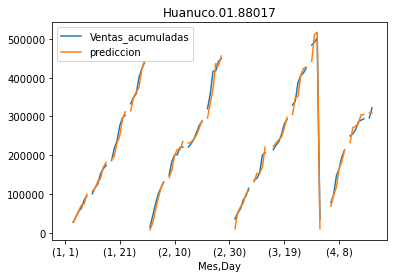

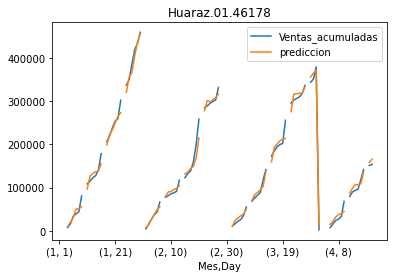

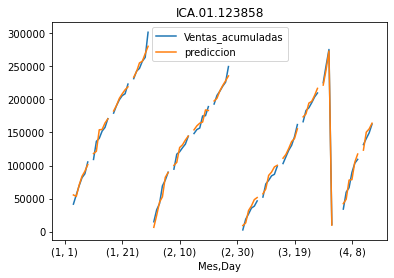

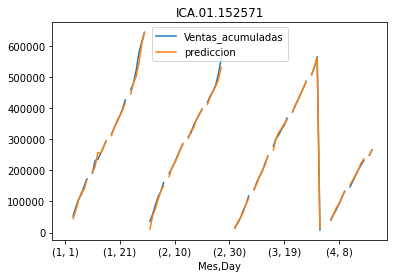

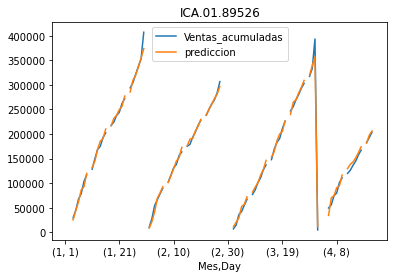

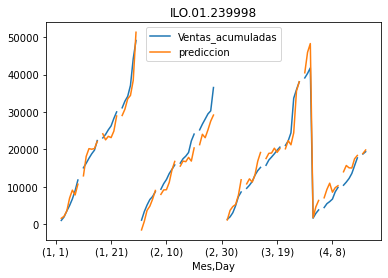

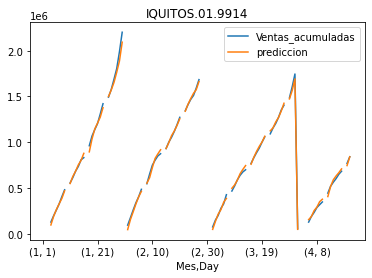

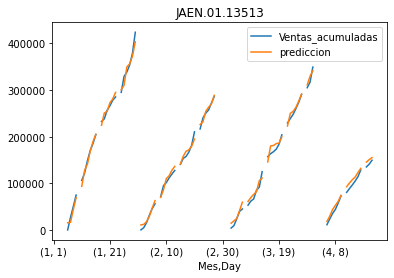

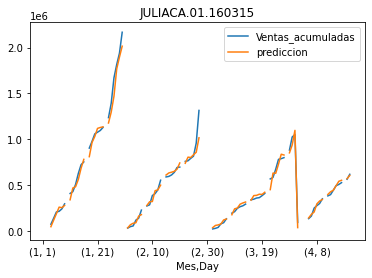

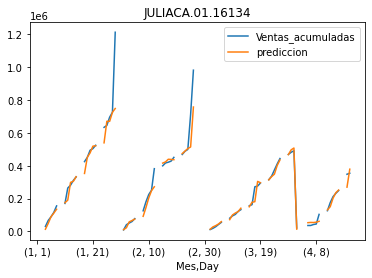

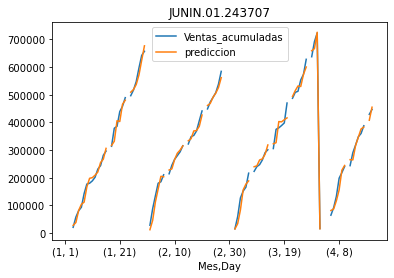

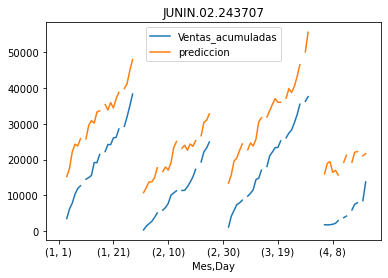

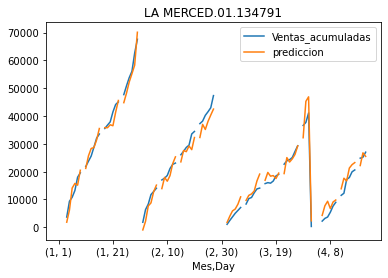

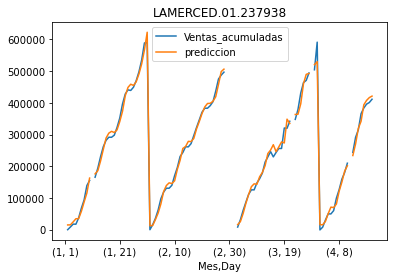

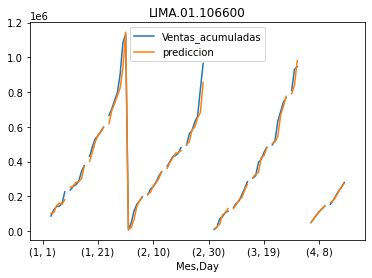

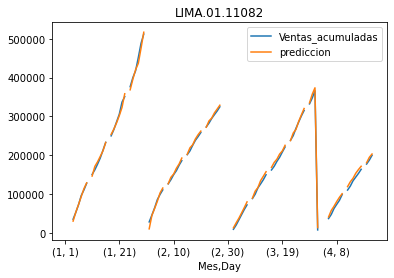

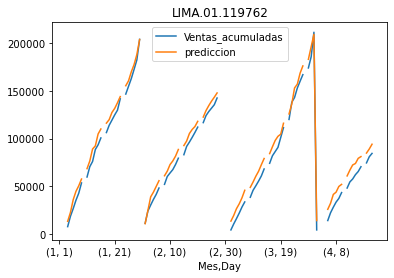

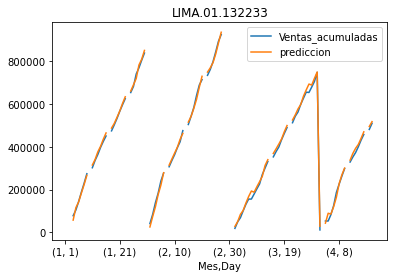

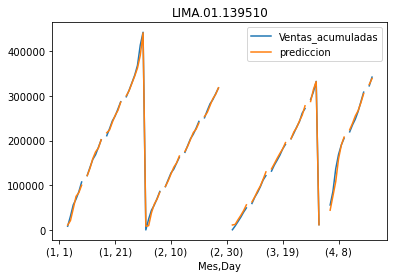

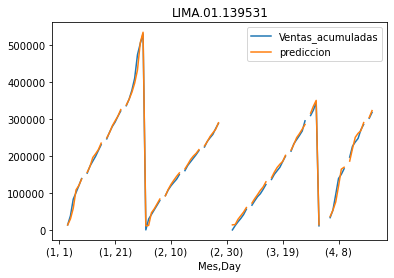

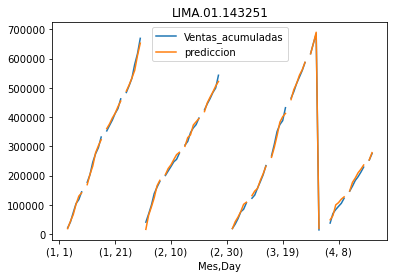

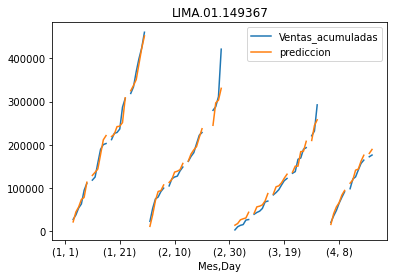

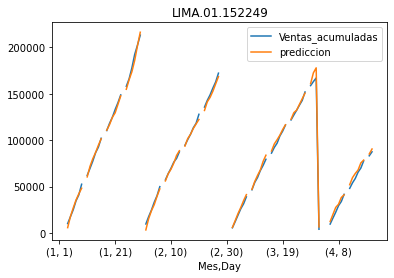

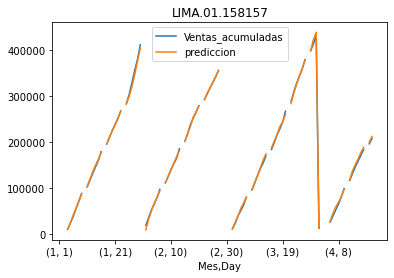

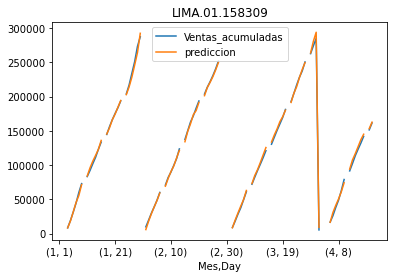

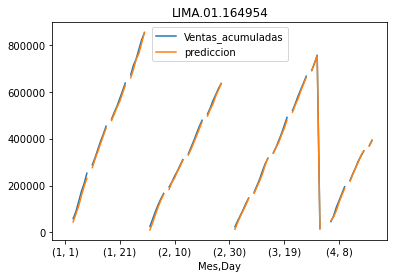

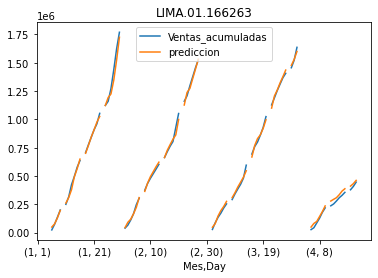

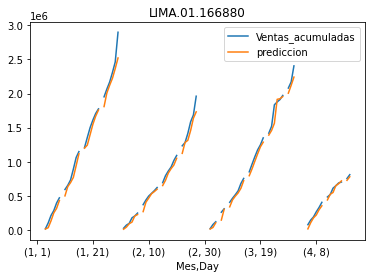

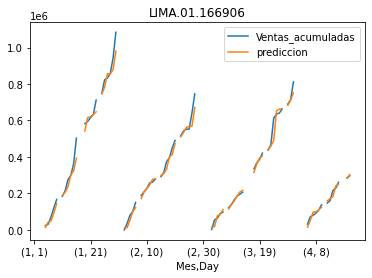

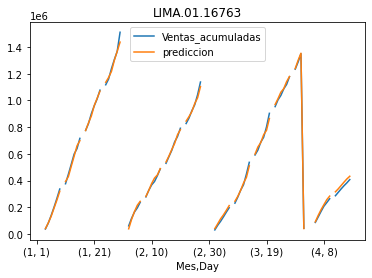

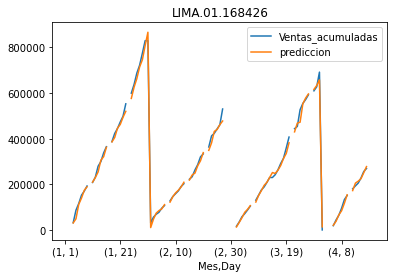

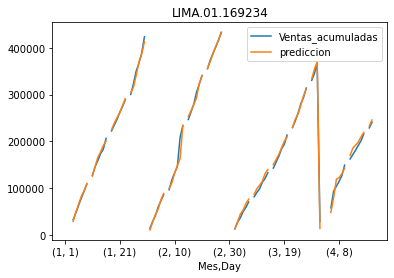

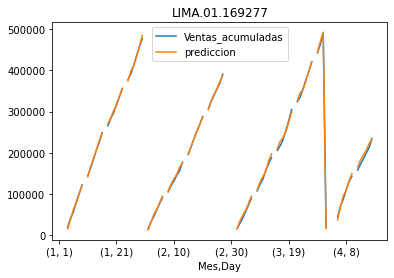

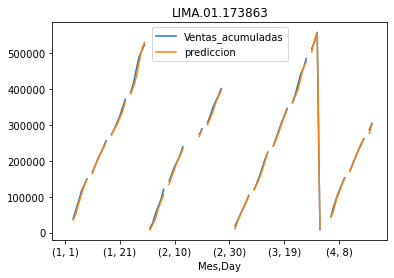

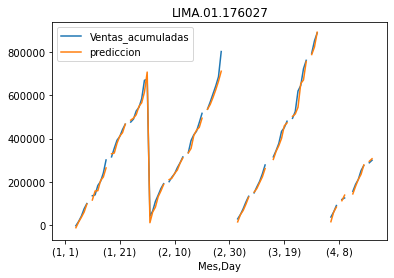

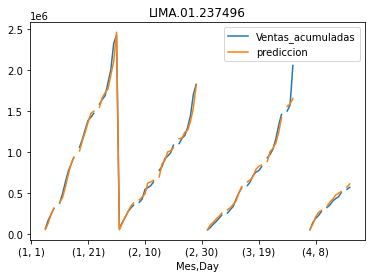

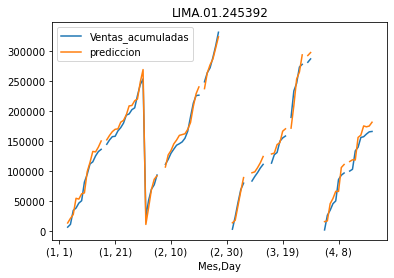

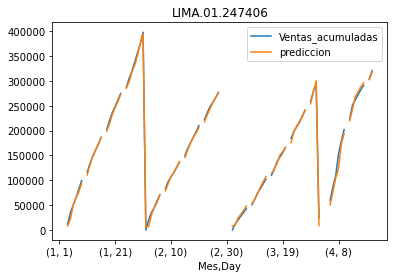

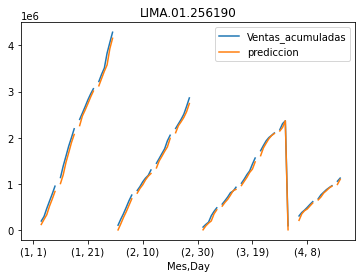

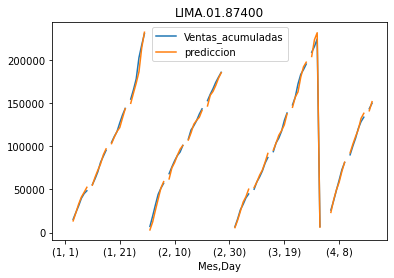

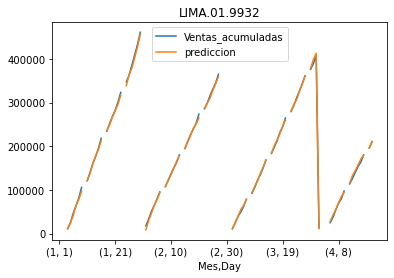

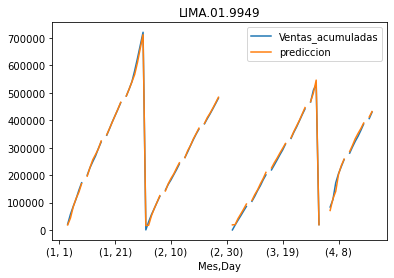

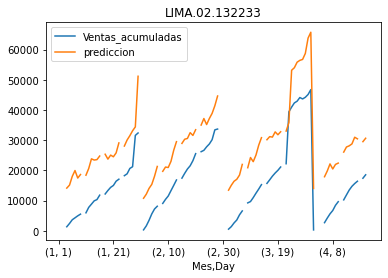

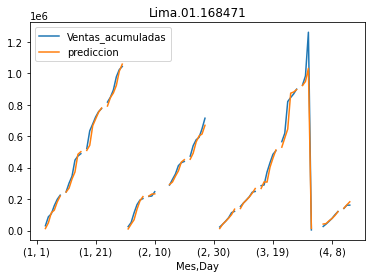

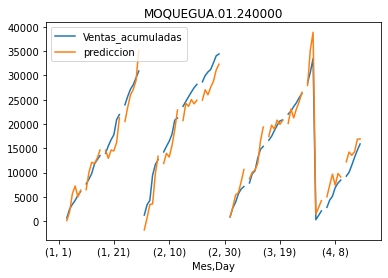

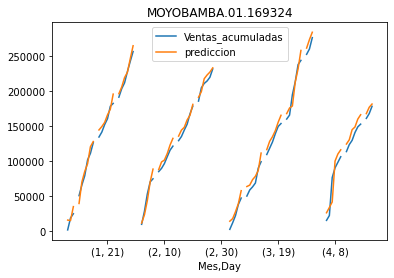

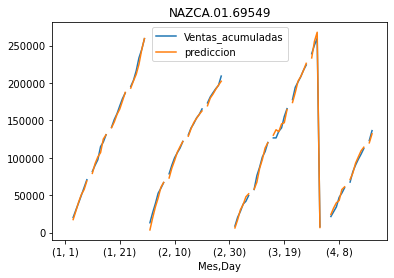

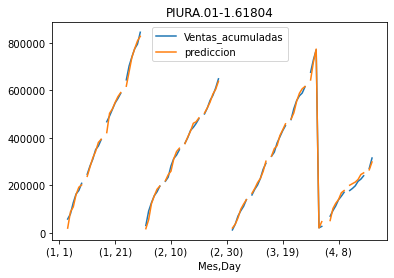

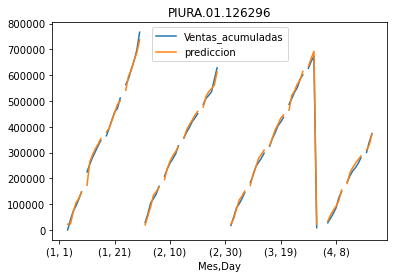

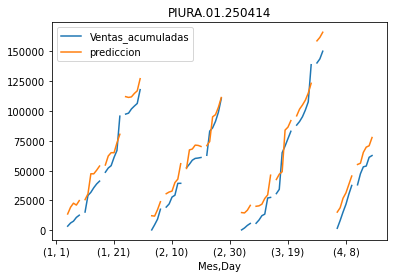

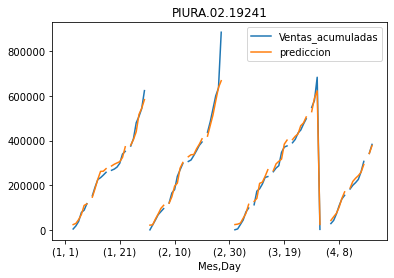

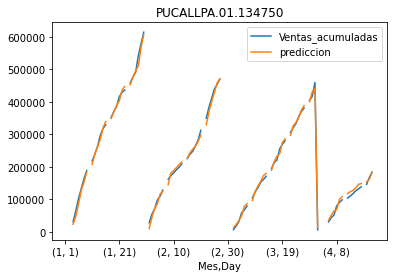

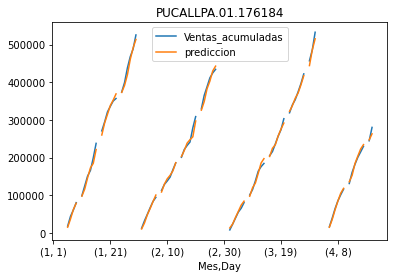

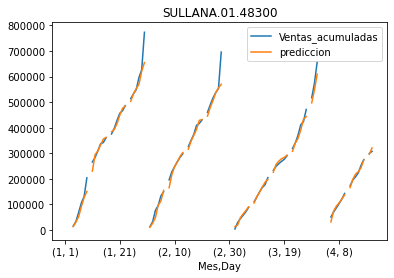

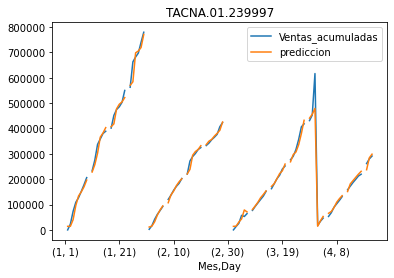

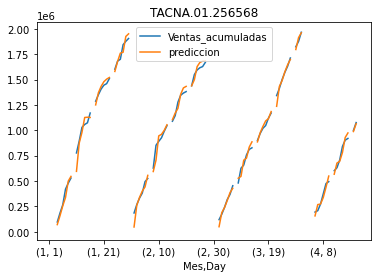

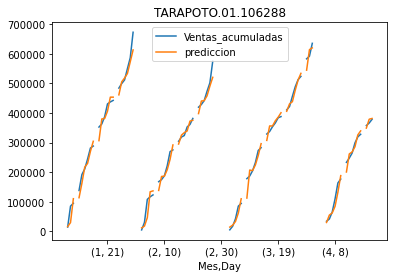

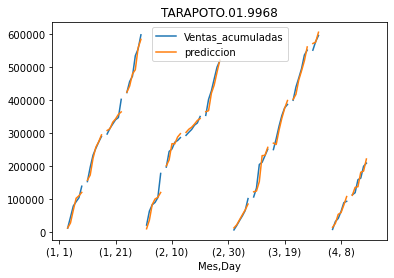

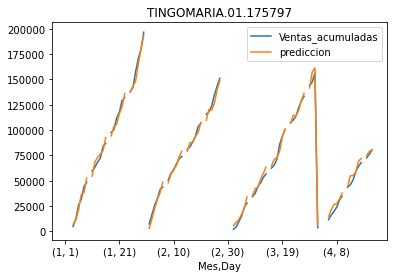

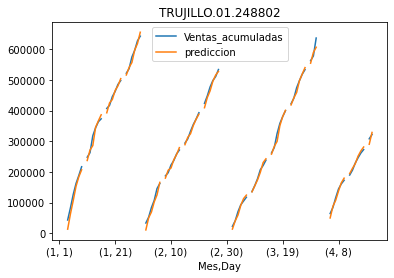

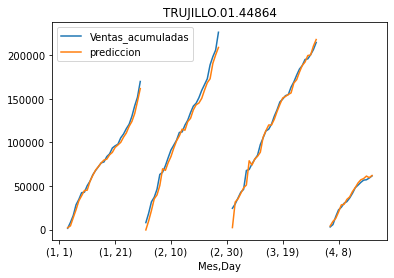

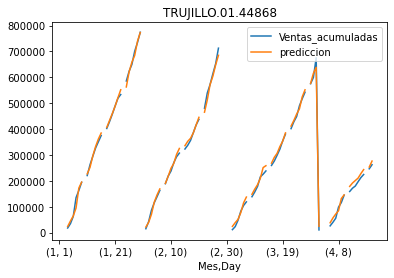

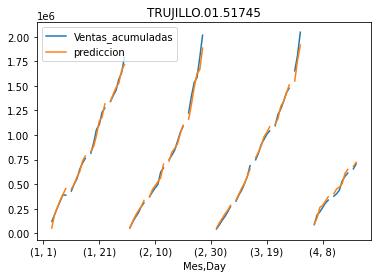

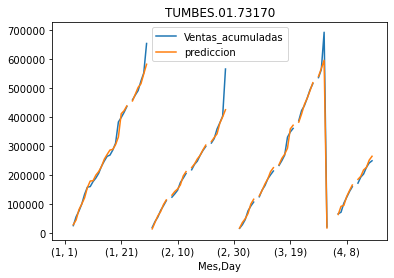

In [28]:
for i in test_data_2021.CodigoDistribuidor.unique():
    _ = test_data_2021[test_data_2021.CodigoDistribuidor == i].groupby(['Mes','Day'])[['Ventas_acumuladas','prediccion']].mean().plot()
    _ = plt.title(i)
    plt.show()

In [29]:
test_data_2021[['Ventas_acumuladas','prediccion']].sample(10)

Ventas_acumuladas     prediccion
2866         43367.7300   24893.948799
4971        152870.4500  154374.996075
7914        352376.0900  306489.013904
6088        452957.2045  497330.283487
970         258443.2521  257262.010515
4210        128527.8986  129417.984343
7382         44416.0100   48637.562750
6581        145343.2356  142368.297950
5141        821889.9200  807685.795226
857          28285.4305   25597.262060

In [30]:
test_data_2021.to_csv('data_2021.csv')